# ***Patent Litigations Disparities: Who are the Real Winners and Losers?***

Research Question: How do  Litigation Outcomes impact the Profitibility and Reseach Investment of firms that are involved in Patent Lawsuits?

# ***Section 1: Introduction:***

Patent litigation is a double-edged sword; while it protects intellectual property, it also imposes financial and strategic costs on firms. Besides the private cost to firms, patents also shape market dynamics and innovation, thus, it is imperative to understand the true impact of patent litigations, in order to determine, if there is a net beenefit for society. To this end, this paper examines how litigation affects profitability and R&D investment in firms involved in patent disputes.

Patent lawsuits are costly, often exceeding potential revenue gains (Bessen & Meurer, 2012). Firms facing litigation tend to experience negative abnormal stock returns (Licht & Cremers, 2013), and litigation uncertainty disrupts long-term financial planning (Cohen et al., 2018). All of these could be disincentivizing the firms' future investment in research, which could lead to worse outcomes for society at large as medicines and improved technology take longer to develop. At the sane time, some plaintiffs can benefit as lawsuits can increase stock prices (Cremers et al., 2018) and serve as a competitive tool, particularly in tech industries (Kang & Nam, 2016).

The impact on R&D investment is less clear. Some firms increase R&D spending to strengthen their patent portfolios (Lin & Lin, 2021), while others, especially defendants, cut innovation budgets due to financial constraints (Hall, 2019). This paper analyzes how litigation outcomes such as dismissals, settlements and judgments can shape these effects using regression analysis on publicly traded firms and public records of patent litigations.

By comparing plaintiffs and defendants, this paper focuses on whether disparities exist. We explore whether litigations contribute primarily to a financial drain or a strategic advantage and whether it stimulates or stifles innovation. These insights are crucial for understanding the broader economic implications of the judicial system, with regards to patents, and whether it justifies the cost-benefit trade-off, in its current form.

# ***Section 2: Data Cleaning/Loading:***

In [1]:
#loading useful packages
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import statsmodels.api as sm
import statsmodels.formula.api as smf
!pip install stargazer
from stargazer.stargazer import Stargazer
from IPython.display import HTML

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#loading csv's that have been a little precleaned and merged to avoid excessive
#lines of code for the cleaning section

#loading up csv's into Data Frames
merged_cases_FJC = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/clean_cases_JFC.csv')
subset_plaintiff_npm = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/clean_plaintiff_npm.csv')
subset_defendent_npm = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/clean_defendent_npm.csv')
subset_plaintiff_RnD = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/clean_plaintiff_RnD.csv')
subset_defendent_RnD = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/clean_defendent_RnD.csv')

In [3]:
#creating plaintiff-only df with all the Y and X variables
#(no index or geospatial data)
plaintiffs_complete = pd.merge(subset_plaintiff_npm,
                               subset_plaintiff_RnD[['case_row_id',
                                                     "delta_rnd_sales"]],
                               on="case_row_id",
                               how = 'outer')

plaintiffs_complete['case_length'] = np.log(plaintiffs_complete['case_length'])

plaintiffs_complete = plaintiffs_complete.drop_duplicates()
plaintiffs_complete = plaintiffs_complete[["case_number", "PLT", 'date_filed',
                            "delta_npm", "delta_rnd_sales","disp_dismissed",
                            "disp_settled", "disp_before_issue_joined",
                            "infringement_35_271", 'disp_judgment',
                            'judgment_monetary_award', 'judgment_injunction',
                            'judgment_ordered_loss', 'judgment_for_defendent',
                            'jury_demand_defendent', 'jury_demand_both',
                            "case_length", "info_tech", "health_care",
                            'materials','consumer_discretionary'
                             ]]

In [4]:
#creating defendent-only df with all the Y and X variables,
#(no index or geospatial data)
defendents_complete = pd.merge(subset_defendent_npm,
                               subset_defendent_RnD[['case_row_id',
                                                     "delta_rnd_sales"]],
                               on="case_row_id",
                               how = 'outer')

defendents_complete = defendents_complete.drop_duplicates()
defendents_complete = defendents_complete[["case_number", "DEF", 'date_filed',
                            "delta_npm", "delta_rnd_sales","disp_dismissed",
                            "disp_settled", "disp_before_issue_joined",
                            "infringement_35_271", 'disp_judgment',
                            'judgment_monetary_award', 'judgment_injunction',
                            'judgment_ordered_loss', 'judgment_for_defendent',
                            'jury_demand_defendent', 'jury_demand_both',
                            "case_length", "info_tech", "health_care",
                            'materials','consumer_discretionary'
                             ]]

**Data Sources:**
The data above are from the Assigned Kaggle Source, the Integrated Database of the Federal Judicial Center(FJC) and Finantial Data of publicly listed firms from the Compustat Database maintained by Wharton Research Data Services(WRDS). The FJC source added case outcomes such as whether ir was dismissed, went to judgment, settled etc. and the Compustat source added Financial data as well as GICS industry classifications. The merging process isnt shown as it was extremely long and included sending SQL queries to Compustat, Creating Dummies through complex processes(owing to structure of raw data) and matching financial data for firms with right timeline. The financial data from Compustat was of Quarterly Frequency and thus was matched based on the quarter of case filing and quarter of case closing, and cases that didn't span two distinct financial quarters were filtered out.



**Explanation of the Variables:**

Both dataframes defendents_complete and plaintiffs_complete conatain the same variables, for each unique case that was matched with WRDS dataset of publicly traded firms. The unit of observation is unique patent cases in both.

delta_npm: change in firm's net profit margin (0.01 = 1 percentage point)

delta_rnd_sales: change in firm's R&D to sales Ratio (0.01 = 1 percentage point)

disp_dismissed: dummy indicating whether a case was dismissed(reference represents cases that were resolved via judgment)

disp_settled: dummy that indicates if a case was dismissed, involved a settlement(this is only for rows where disp_dismissed = 1)

disp_before_issue_joined: dummy that indicates whether a case was dismissed before issue was joined(this means no legal proceedings were actually conducted between the case's filing and dismisssal, also only for rows with disp_dismissed = 1 )

infringement_35_271: dummy that indicates whether a case was filed Under 35 U.S.C. § 271(this essentially means that direct patent infringement was alleged by plaintiff)

case_length: the natural log of total days between a case's filing and closing(this variable has an extreme right skew, thus a natural log was applied)

info_tech: a dummy that indicates whether a given firm is classied as part of the information technology sector, under the GICS sector classification system(the reference category is all firms not in the info-tech sector)

health_care: a dummy that indicates whether a given firm is classied as part of the healthcare sector, under the GICS sector classification system(the reference category is all firms not in the info-tech sector)

Only two dummies for sector fixed effects were used because other sectors had very few occurrences in the merged dataset.

# ***Section 3: Summary Statistics:***

In [5]:
plaintiffs_complete.describe()

,delta_npm,delta_rnd_sales,disp_dismissed,disp_settled,disp_before_issue_joined,infringement_35_271,disp_judgment,judgment_monetary_award,judgment_injunction,judgment_ordered_loss,judgment_for_defendent,jury_demand_defendent,jury_demand_both,case_length,info_tech,health_care,materials,consumer_discretionary
count,1147.000000,1157.000000,1147.000000,1147.000000,1147.000000,1147.000000,1147.000000,305.000000,305.000000,305.000000,305.000000,601.000000,601.000000,1147.000000,1147.000000,1147.000000,1147.000000,1147.000000
mean,8.741107,-0.764724,0.734089,0.619006,0.280732,0.517001,0.265911,0.065574,0.085246,0.032787,0.200000,0.038270,0.216306,5.879307,0.393200,0.258936,0.069747,0.118570
std,184.206505,82.468427,0.442010,0.485843,0.449553,0.499929,0.442010,0.247942,0.279706,0.178371,0.400657,0.192006,0.412068,0.955752,0.488674,0.438242,0.254832,0.323423
min,-348.520087,-1273.693333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.044522,0.000000,0.000000,0.000000,0.000000
25%,-0.033832,-0.003042,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.167635,0.000000,0.000000,0.000000,0.000000
50%,-0.000521,0.000473,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.940171,0.000000,0.000000,0.000000,0.000000
75%,0.025305,0.010271,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.631341,1.000000,1.000000,0.000000,0.000000
max,3594.053333,1212.250000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.343078,1.000000,1.000000,1.000000,1.000000


Based on the summary stats for the plaintiffs, we can see that there is a strong right skew in the delta_npm. delta_rnd_sales aseems normally distributed around 0.

The case_length has already been logged, due to a large skew. It appears to be fairly evenly distributed betwen the range of 1 to 8.

The cateogrorical variables all appear to be evenly ditributed between 0 and 1.

In [6]:
defendents_complete.describe()

,delta_npm,delta_rnd_sales,disp_dismissed,disp_settled,disp_before_issue_joined,infringement_35_271,disp_judgment,judgment_monetary_award,judgment_injunction,judgment_ordered_loss,judgment_for_defendent,jury_demand_defendent,jury_demand_both,case_length,info_tech,health_care,materials,consumer_discretionary
count,2557.000000,2559.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,470.000000,470.000000,470.00000,470.000000,2062.000000,2062.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000
mean,-0.079224,0.013422,0.816191,0.604615,0.417677,0.633164,0.183809,0.055319,0.019149,0.02766,0.368085,0.027643,0.325412,5.586688,0.147438,0.386390,0.026203,0.154478
std,3.238747,0.720413,0.387404,0.489029,0.493273,0.482036,0.387404,0.228846,0.137194,0.16417,0.482799,0.163988,0.468642,0.966711,0.354612,0.487017,0.159769,0.361477
min,-152.326629,-7.251561,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000
25%,-0.019312,-0.001439,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,4.867534,0.000000,0.000000,0.000000,0.000000
50%,0.001188,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,5.583496,0.000000,0.000000,0.000000,0.000000
75%,0.021006,0.003631,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,1.000000,6.311735,0.000000,1.000000,0.000000,0.000000
max,18.700229,31.787848,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,8.628019,1.000000,1.000000,1.000000,1.000000


Looking at the summary statistics for the defendants, we see that both the outcome variables are distributed around 0 but delta_npm appears to have a strong negative skew while delta_rnd_sales has strong positive skew. This could be an indication that litigatoin tends to lower defendants' profit margins but in some instances, leads to increase in research spending.

The categories once again seem evenly distributed with th exception of a larger proportion of 0s in disp_before_issue_joined.

Overall no major issues in both sets of plaintiff and defendant data, except for the skew inside the delta_npm variables

# ***Section 4: Data Visualizations:***

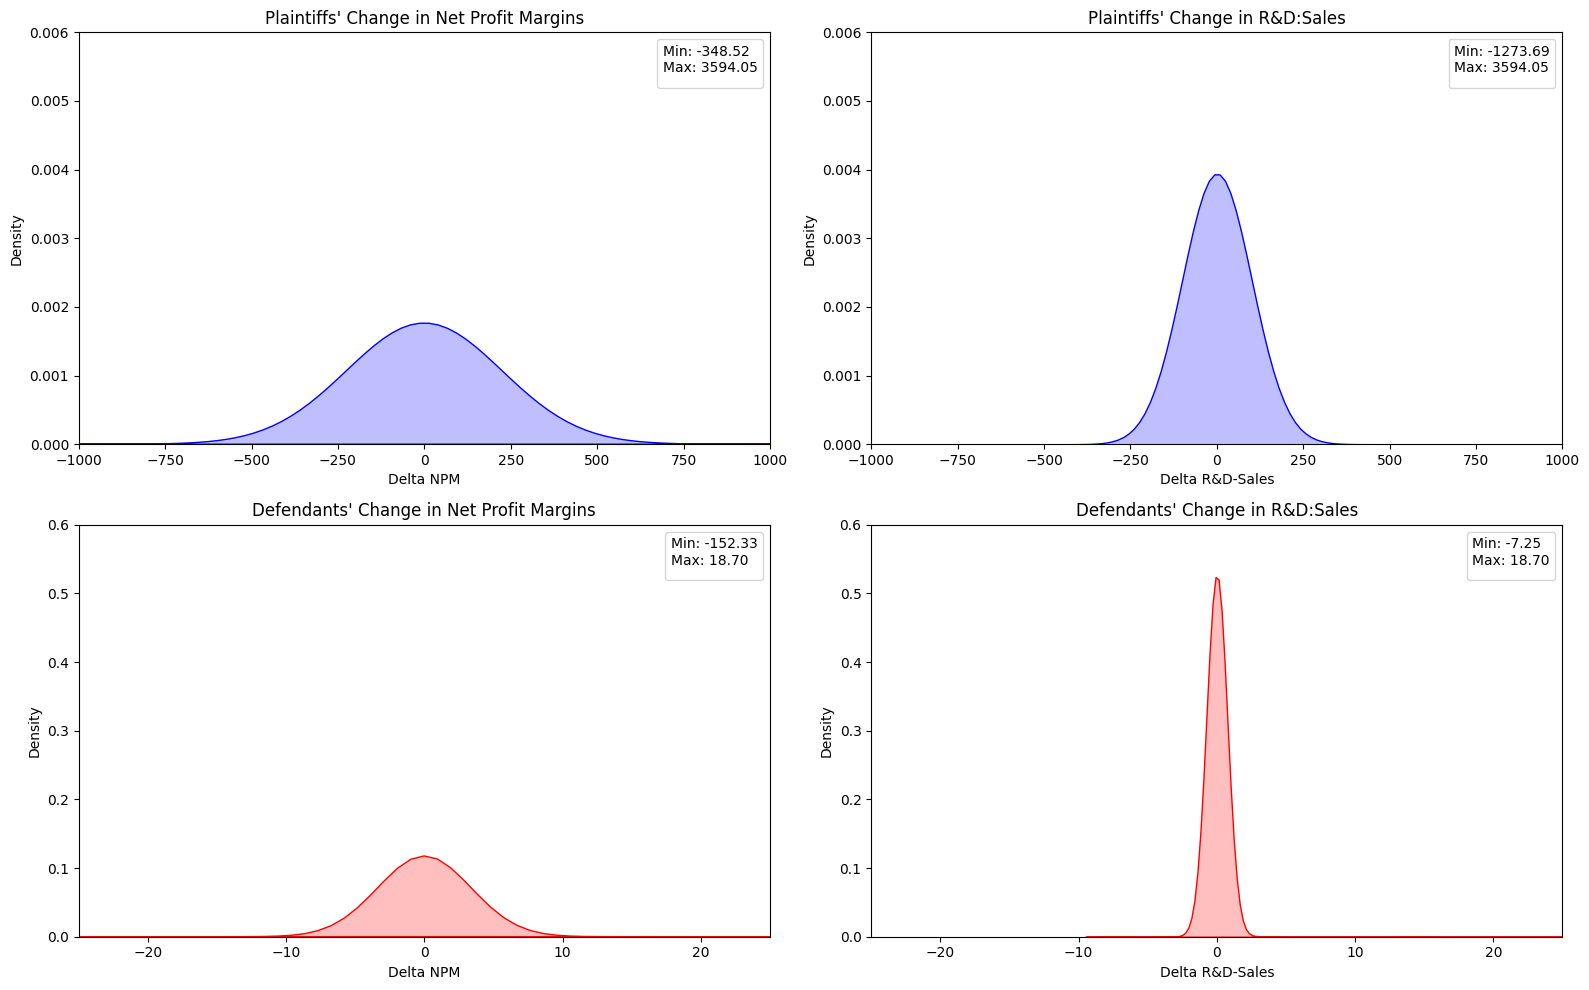

In [7]:
# Density plots for NPM and RnD:Sales
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot KDE for plaintiffs NPM
sns.kdeplot(plaintiffs_complete["delta_npm"],
            fill=True, color="blue", ax=axes[0,0],bw_adjust=5)
axes[0,0].set_title("Plaintiffs' Change in Net Profit Margins")
axes[0,0].set_xlabel("Delta NPM")
axes[0,0].set_ylabel("Density")
axes[0,0].grid(False)

# Plot KDE for defendants NPM
sns.kdeplot(defendents_complete["delta_npm"],
            fill=True, color="red", ax=axes[1,0],bw_adjust=5)
axes[1,0].set_title("Defendants' Change in Net Profit Margins")
axes[1,0].set_xlabel("Delta NPM")
axes[1,0].grid(False)

# Plot KDE for plaintiffs Rnd
sns.kdeplot(plaintiffs_complete["delta_rnd_sales"],
            fill=True, color="blue", ax=axes[0,1], bw_adjust=5)
axes[0,1].set_title("Plaintiffs' Change in R&D:Sales")
axes[0,1].set_xlabel("Delta R&D-Sales")
axes[0,1].set_ylabel("Density")
axes[0,1].grid(False)

# Plot KDE for defendants Rnd
sns.kdeplot(defendents_complete["delta_rnd_sales"],
            fill=True, color="red", ax=axes[1,1],bw_adjust=5)
axes[1,1].set_title("Defendants' Change in R&D:Sales")
axes[1,1].set_xlabel("Delta R&D-Sales")
axes[1,1].grid(False)


# Add min and max values as text legend
axes[0,0].legend(
    handles=[],
    title=f"Min: {plaintiffs_complete['delta_npm'].min():.2f}\nMax: {plaintiffs_complete['delta_npm'].max():.2f}",
    loc="upper right")
axes[1,0].legend(
    handles=[],
    title=f"Min: {defendents_complete['delta_npm'].min():.2f}\nMax: {defendents_complete['delta_npm'].max():.2f}",
    loc="upper right")
axes[0,1].legend(
    handles=[],
    title=f"Min: {plaintiffs_complete['delta_rnd_sales'].min():.2f}\nMax: {plaintiffs_complete['delta_npm'].max():.2f}",
    loc="upper right")
axes[1,1].legend(
    handles=[],
    title=f"Min: {defendents_complete['delta_rnd_sales'].min():.2f}\nMax: {defendents_complete['delta_npm'].max():.2f}",
    loc="upper right")



#zooming into the peaks
axes[0,0].set_ylim(0, 0.006)
axes[0,0].set_xlim(-1000, 1000)
axes[1,0].set_ylim(0, 0.6)
axes[1,0].set_xlim(-25, 25)
axes[0,1].set_ylim(0, 0.006)
axes[0,1].set_xlim(-1000, 1000)
axes[1,1].set_ylim(0, 0.6)
axes[1,1].set_xlim(-25, 25)

plt.tight_layout()
plt.show()

The above figure illusutrates the Kernel Density Estimated distributions for the outcome variables, for plaintiffs and defendants. Kernel Density plots better visualize these data as simple barcharts fail to effecitvely visualize intersting features of the distributions. The number of bins is either too small and leads one tall bar the others are near-invisible or if the number of bins is really high, it shows extremely thin bars, which are also hard to see.


We observe that Profit Margins have considerable smaller peaks and larger spreads, relative to R&D sales. All four appear normally distributed around zero, but in reality they are all heavily skewed, the visualizes simply zooms in to focus on the peaks.

Additionally, the distributions of changes in NPM and the R&D/sales ratio for defendants, appear to gave much lower spread compared to their plaintiff counterparts and the distributions of R&D change are much narrower than those of Net Profit Marings.

The skews, aren't entirely visible but denoted via the Max and Min values. We observe that for Net Profit Margins, the defendants have a left skew while plaintiffs have a strong right skew. This demonstrates disparities in outcomes, defendants tend to have decreases in profit margins while plaintiffs have increases.

We also observe that the R&D distributions for both plaintiffs and defendents are both skewed to the right, however, platintiffs' tail is considerably larger than the defendants.

In [8]:
plaintiffs_complete['delta_rnd_sales'].isna().sum()

np.int64(0)

In [9]:
plaintiffs_complete.isna().sum()

,0
case_number,10
PLT,10
date_filed,10
delta_npm,10
delta_rnd_sales,0
disp_dismissed,10
disp_settled,10
disp_before_issue_joined,10
infringement_35_271,10
disp_judgment,10


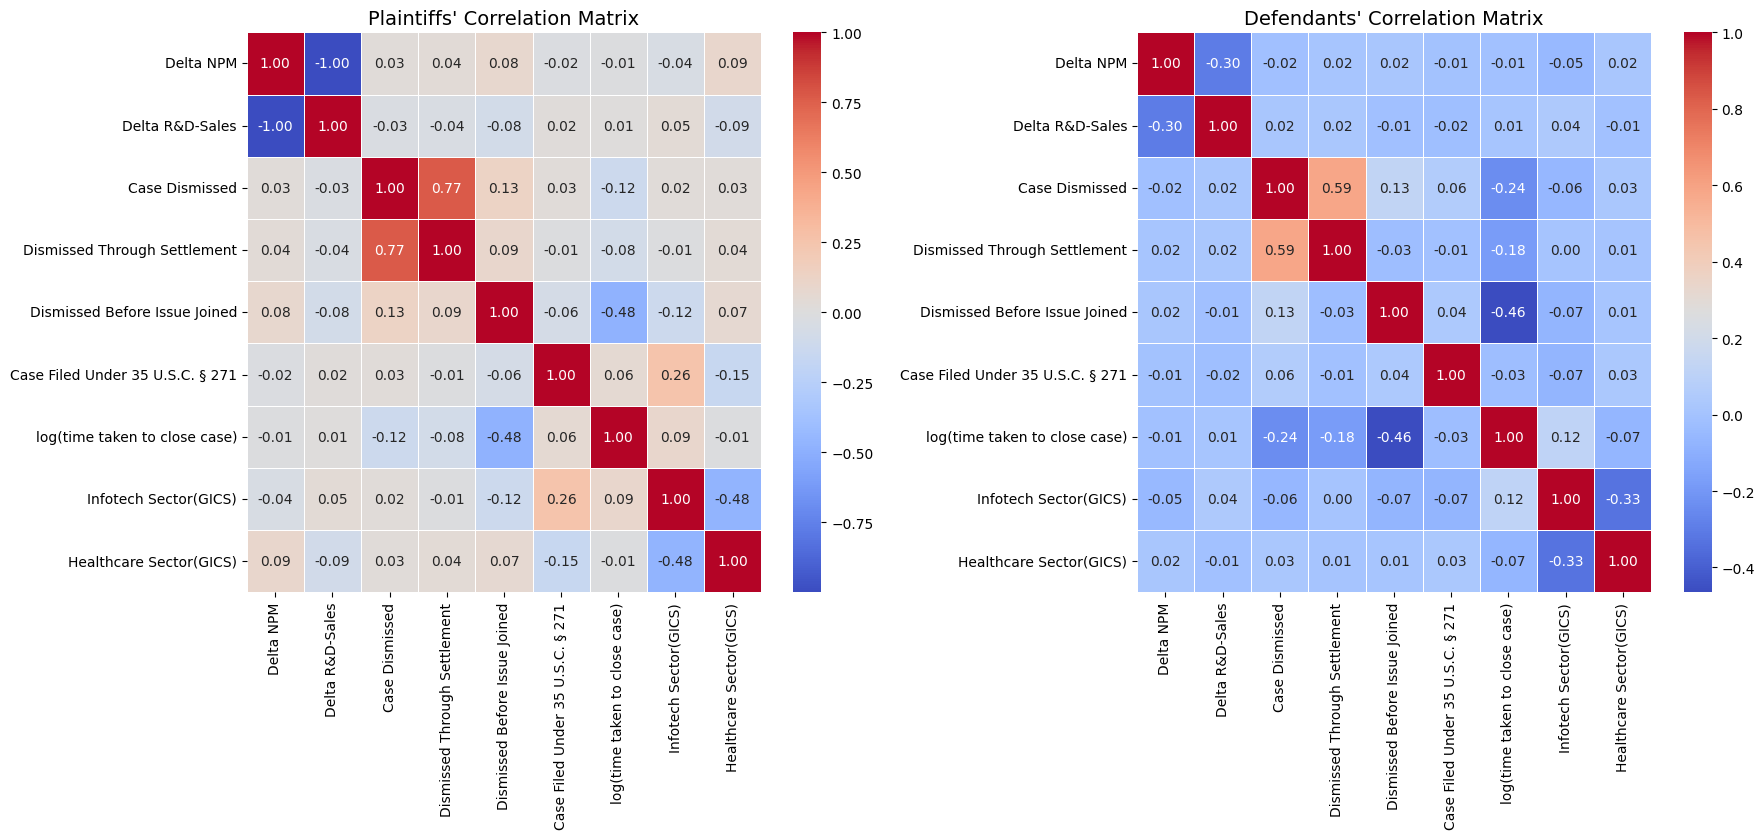

In [10]:
# Compute correlation matrices
corr_matrix_plt = plaintiffs_complete[[
    'delta_npm', 'delta_rnd_sales', 'disp_dismissed', 'disp_settled',
    'disp_before_issue_joined', 'infringement_35_271', 'case_length',
    'info_tech', 'health_care'
    ]].corr()
corr_matrix_def = defendents_complete[[
    'delta_npm', 'delta_rnd_sales', 'disp_dismissed', 'disp_settled',
    'disp_before_issue_joined','infringement_35_271', 'case_length',
    'info_tech', 'health_care'
    ]].corr()

# Rename labels using the provided mapping
label_mapping = {
    "delta_npm": "Delta NPM",
    "delta_rnd_sales": "Delta R&D-Sales",
    "disp_dismissed": "Case Dismissed",
    "disp_settled": "Dismissed Through Settlement",
    "disp_before_issue_joined": "Dismissed Before Issue Joined",
    "infringement_35_271": "Case Filed Under 35 U.S.C. § 271",
    "case_length": "log(time taken to close case)",
    "info_tech": "Infotech Sector(GICS)",
    "health_care": "Healthcare Sector(GICS)",
    "materials": "Materials Sector(GICS)",
    "industrials": "Industrials Sector(GICS)",
    "consumer_discretionary": "Consumer Discretionary Sector(GICS)"
}

# Apply clean labels
corr_matrix_plt = corr_matrix_plt.rename(columns=label_mapping, index=label_mapping)
corr_matrix_def = corr_matrix_def.rename(columns=label_mapping, index=label_mapping)

# Create the subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 10))  # Increase size for clarity

# Plot for Plaintiffs
sns.heatmap(corr_matrix_plt, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, ax=axes[0])
axes[0].set_title("Plaintiffs' Correlation Matrix", fontsize=14)
axes[0].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability
axes[0].tick_params(axis='y', rotation=0)   # Keep y-axis labels straight

# Plot for Defendants
sns.heatmap(corr_matrix_def, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, ax=axes[1])
axes[1].set_title("Defendants' Correlation Matrix", fontsize=14)
axes[1].tick_params(axis='x', rotation=90)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout(rect=[0, 0.15, 1, 1])
plt.show()

The Correlation Matricies show, similar small and negative correlations between the variables. These figures also illustrate the disparities between plaintiffs and defendants.

The only highly strong correlation is between the plaintiffs Profits and R&D investment(real value is about 0.992, rounded up by python). This seems to suggest that the plaintiff firms are systematically different from defendents in the sensse that they invest heavily in research to the detriment of their profitability.

The corrleation between dismissals and dismissals with settlement is expected as only cases that are dismissed can involve settlements. Therefore, this relationship is definitional. The dummies for info-tech and healthcare are also correlated simply because they are mutually exclusive categories.

Plaintffs seem to have small, positive correlations and some small negative correlations between the profit/R&D and litigation outcomes.
Defendants on the other hand only have small negative correlations. This is also expected as defendants, having been accused of patent rights violations, have more to lose than the party that brings legal action.


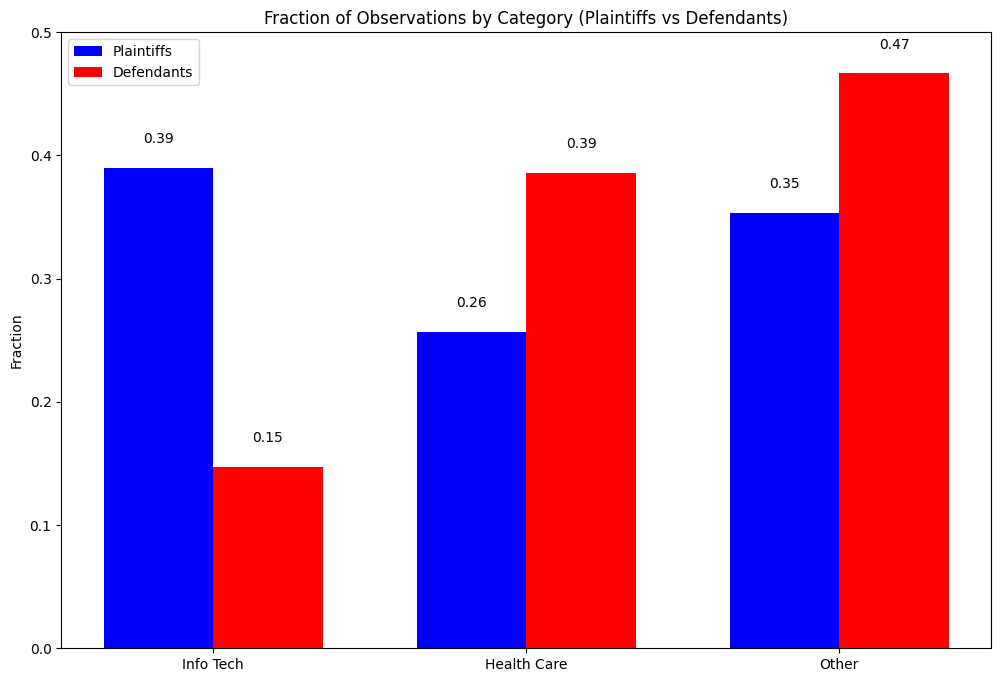

In [11]:
# Function to calculate fractions
def calculate_fractions(df):
    info_tech_count = df['info_tech'].sum()
    health_care_count = df['health_care'].sum()
    total_count = len(df)
    other_count = total_count - (info_tech_count + health_care_count)

    return [info_tech_count / total_count, health_care_count / total_count, other_count / total_count]

# Calculate fractions for both datasets
plaintiffs_fractions = calculate_fractions(plaintiffs_complete)
defendents_fractions = calculate_fractions(defendents_complete)

# Bar chart settings
categories = ['Info Tech', 'Health Care', 'Other']
x = np.arange(len(categories))  # X locations
width = 0.35  # Width of bars

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot bars
bars1 = ax.bar(x - width/2, plaintiffs_fractions, width, label='Plaintiffs', color='blue')
bars2 = ax.bar(x + width/2, defendents_fractions, width, label='Defendants', color='red')

# Labels, Title, and Legend
ax.set_ylabel('Fraction')
ax.set_title('Fraction of Observations by Category (Plaintiffs vs Defendants)')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Show values on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.2f}", ha='center', fontsize=10)

# Show plot
ax.set_ylim(0, 0.5)
plt.show()

This plot illustrates the differences between the plaintiff and defendent firms, in terms of the sectors that they operate in.

Plaintiffs appear to have the highest concentration of IT firms, followed by Healthcare and the reference category.

The Defendants on the other hand have a higher concentration of the other, followed by health care and IT.

We only explicitly included IT and Healthcare categories because overall, these two categories had considerably more occurrences in the dataset, compared to other sectors. Thus, we only account for fixed effects of IT and Healthcare sectors while also reducing multi-collinearity by having too many dummies for the same category.

# ***Section 5: The Message:***

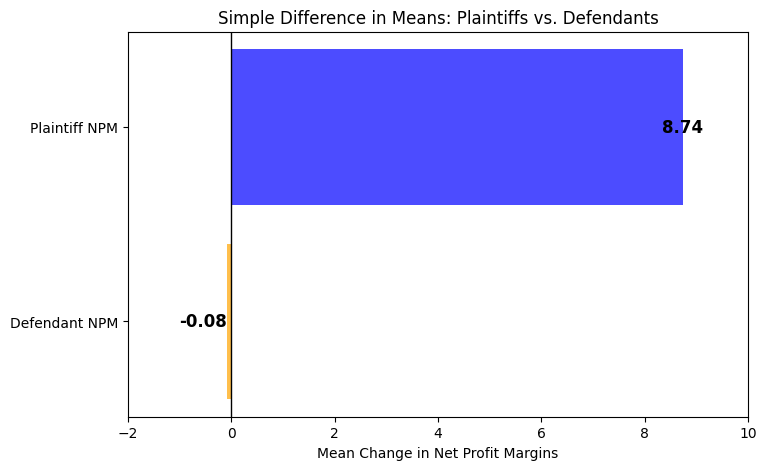

In [12]:
# Compute means
mean_plaintiff = plaintiffs_complete["delta_npm"].mean()
mean_defendant = defendents_complete["delta_npm"].mean()

# Define categories and means
categories = ["Defendant NPM", "Plaintiff NPM"]  # Defendant first so negative is on the left
means = [mean_defendant, mean_plaintiff]  # Order matters!

# Create the horizontal bar plot
plt.figure(figsize=(8, 5))
plt.barh(categories, means, color=["orange", "blue"], alpha=0.7)

# Annotate mean values on bars
for i, mean in enumerate(means):
    plt.text(mean, i, f"{mean:.2f}", ha="center" if mean > 0 else "right",
             va="center", fontsize=12, fontweight="bold", color="black")

# Improve readability
plt.axvline(0, color="black", linewidth=1)  # Add vertical line at x=0 for reference
plt.xlabel("Mean Change in Net Profit Margins")
plt.title("Simple Difference in Means: Plaintiffs vs. Defendants")
plt.xlim(-2,10)

# Show plot
plt.show()


**The Message:** Significant disparities exist between firms that sue over patent rights and firms that are being sued.\


**Interpretation of the Figure:**
The Change in Net Profit Margins variable is computed by computing the difference between the Net Profit Margin of each firm in the financial quarter of case closing and the Net Profit Margin of eacah firm in the financial quarter of case filing.

Plaintiffs are observed to have a 874 percentage point increase(0.01 = 1 percent point) in profit margins, on average, whereas Defendents are observed to have a 8 percentage point decrease in their profit margins, on average. This effectively summarizes the existance of disparities; Plaintiffs that bring legal action based on patent rights, tend to profit significantly while defendents are observed to have declined profitability.

# ***Section 6: Maps:***

In [13]:
#loading up a precleaned gdf to reduce amount of cleaning code displayedx
map_gdf = gpd.read_file('/content/drive/My Drive/ECO225_Final_Project/DATA/cleaned_data.gpkg')

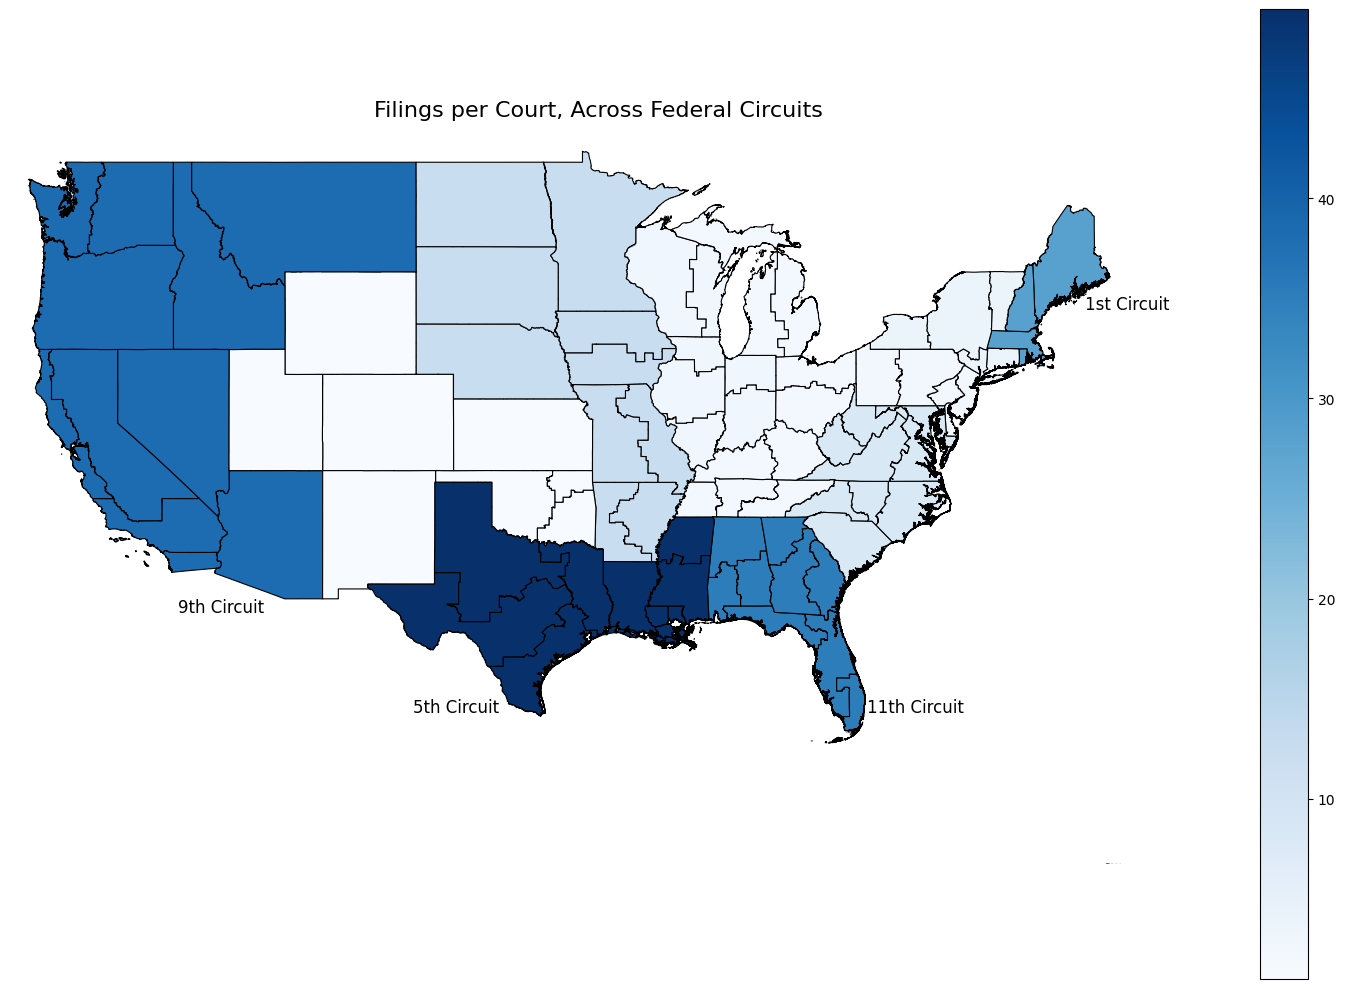

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))

map_gdf.plot(column="filings_per_court",
             cmap="Blues",
             linewidth=0.8,
             edgecolor="black",
             legend=True,
             ax=ax)

ax.set_title("Filings per Court, Across Federal Circuits", fontsize=16)
ax.axis("off")  # Hide axis labels
ax.set_xlim([-1.4e7, -7e6])
ax.set_ylim([2.1e6, 6.5e6])

ax.annotate("5th Circuit", xy=(-1.16e7, 3e6), fontsize=12, color='black')
ax.annotate("11th Circuit", xy=(-0.89e7, 3e6), fontsize=12, color='black')
ax.annotate("9th Circuit", xy=(-1.3e7, 3.6e6), fontsize=12, color='black')
ax.annotate("1st Circuit", xy=(-0.76e7, 5.4e6), fontsize=12, color='black')

plt.tight_layout()
plt.show()

The map above portrays the number of case filings per court inside each of the 11 Federal Court Circuits of the Continental United States. We only focus at the 1st, 5th, 9th and 11th circuits, which are all identified with labels and a specific shade of blue that corresponds to filings per court within each circuit.

We observe that for patent suits involving publicly listed companies, the 5th circuit has the highest concentration of filings, followed by the 11th, 9th and the 1st respectively. This hints at potential circuit fixed-effects, such as perceived judge leniency or circuit specific practices that could useful to factor in, at a later stage.

In [15]:
#Manually Mapping out the number codes into district court names for merging :(
court_mapping = {
    "00": "Maine District Court",
    "01": "Massachusetts District Court",
    "02": "New Hampshire District Court",
    "03": "Rhode Island District Court",
    "04": "Puerto Rico District Court",
    "05": "Connecticut District Court",
    "06": "New York Northern District Court",
    "07": "New York Eastern District Court",
    "08": "New York Southern District Court",
    "09": "New York Western District Court",
    "10": "Vermont District Court",
    "11": "Delaware District Court",
    "12": "New Jersey District Court",
    "13": "Pennsylvania Eastern District Court",
    "14": "Pennsylvania Middle District Court",
    "15": "Pennsylvania Western District Court",
    "16": "Maryland District Court",
    "17": "North Carolina Eastern District Court",
    "18": "North Carolina Middle District Court",
    "19": "North Carolina Western District Court",
    "20": "South Carolina District Court",
    "22": "Virginia Eastern District Court",
    "23": "Virginia Western District Court",
    "24": "West Virginia Northern District Court",
    "25": "West Virginia Southern District Court",
    "26": "Alabama Northern District Court",
    "27": "Alabama Middle District Court",
    "28": "Alabama Southern District Court",
    "29": "Florida Northern District Court",
    "3A": "Florida Middle District Court",
    "3C": "Florida Southern District Court",
    "3E": "Georgia Northern District Court",
    "3G": "Georgia Middle District Court",
    "3J": "Georgia Southern District Court",
    "3L": "Louisiana Eastern District Court",
    "3N": "Louisiana Middle District Court",
    "36": "Louisiana Western District Court",
    "37": "Mississippi Northern District Court",
    "38": "Mississippi Southern District Court",
    "39": "Texas Northern District Court",
    "40": "Texas Eastern District Court",
    "41": "Texas Southern District Court",
    "42": "Texas Western District Court",
    "43": "Kentucky Eastern District Court",
    "44": "Kentucky Western District Court",
    "45": "Michigan Eastern District Court",
    "46": "Michigan Western District Court",
    "47": "Ohio Northern District Court",
    "48": "Ohio Southern District Court",
    "49": "Tennessee Eastern District Court",
    "50": "Tennessee Middle District Court",
    "51": "Tennessee Western District Court",
    "52": "Illinois Northern District Court",
    "53": "Illinois Central District Court",
    "54": "Illinois Southern District Court",
    "55": "Indiana Northern District Court",
    "56": "Indiana Southern District Court",
    "57": "Wisconsin Eastern District Court",
    "58": "Wisconsin Western District Court",
    "60": "Arkansas Eastern District Court",
    "61": "Arkansas Western District Court",
    "62": "Iowa Northern District Court",
    "63": "Iowa Southern District Court",
    "64": "Minnesota District Court",
    "65": "Missouri Eastern District Court",
    "66": "Missouri Western District Court",
    "67": "Nebraska District Court",
    "68": "North Dakota District Court",
    "69": "South Dakota District Court",
    "70": "Arizona District Court",
    "71": "California Northern District Court",
    "72": "California Eastern District Court",
    "73": "California Central District Court",
    "74": "California Southern District Court",
    "75": "Hawaii District Court",
    "76": "Idaho District Court",
    "77": "Montana District Court",
    "78": "Nevada District Court",
    "79": "Oregon District Court",
    "80": "Washington Eastern District Court",
    "81": "Washington Western District Court",
    "82": "Colorado District Court",
    "83": "Kansas District Court",
    "84": "New Mexico District Court",
    "85": "Oklahoma Northern District Court",
    "86": "Oklahoma Eastern District Court",
    "87": "Oklahoma Western District Court",
    "88": "Utah District Court",
    "89": "Wyoming District Court",
    "90": "District of Columbia District Court",
    "91": "Virgin Islands District Court",
    "92": "Guam District Court",
    "94": "Northern Mariana Islands District Court",
    "-8": None  # Missing value
}



circuit_mapping = {
    "0": "District of Columbia Circuit",
    "01": "First Circuit",
    '02': "Second Circuit",
    '03': "Third Circuit",
    '04': "Fourth Circuit",
    '05': "Fifth Circuit",
    '06': "Sixth Circuit",
    '07': "Seventh Circuit",
    '08': "Eighth Circuit",
    '09': "Ninth Circuit",
    '10': "Tenth Circuit",
    '11': "Eleventh Circuit",
    'DC': "District of Columbia Circuit",
    '-8': None  # Missing value case
}


merged_cases_FJC["DISTRICT"] = merged_cases_FJC["DISTRICT"].astype(str).map(court_mapping)

In [16]:
#plotting average dismissals/court by Circuits
map_disposals = merged_cases_FJC.groupby("DISTRICT").agg({
    "disp_dismissed": "sum",
    "disp_settled": "sum",
    "disp_before_issue_joined": "sum"})

map_disposals = map_disposals.reset_index()
map_gdf = pd.merge(map_gdf, map_disposals, left_on="NAME" ,right_on="DISTRICT", how="left")

map_gdf['circuit_dismissed'] = map_gdf.groupby("Circuit")["disp_dismissed"].transform('sum')
map_gdf['dismissals_per_court'] = map_gdf['circuit_dismissed']/map_gdf['num_district_courts']

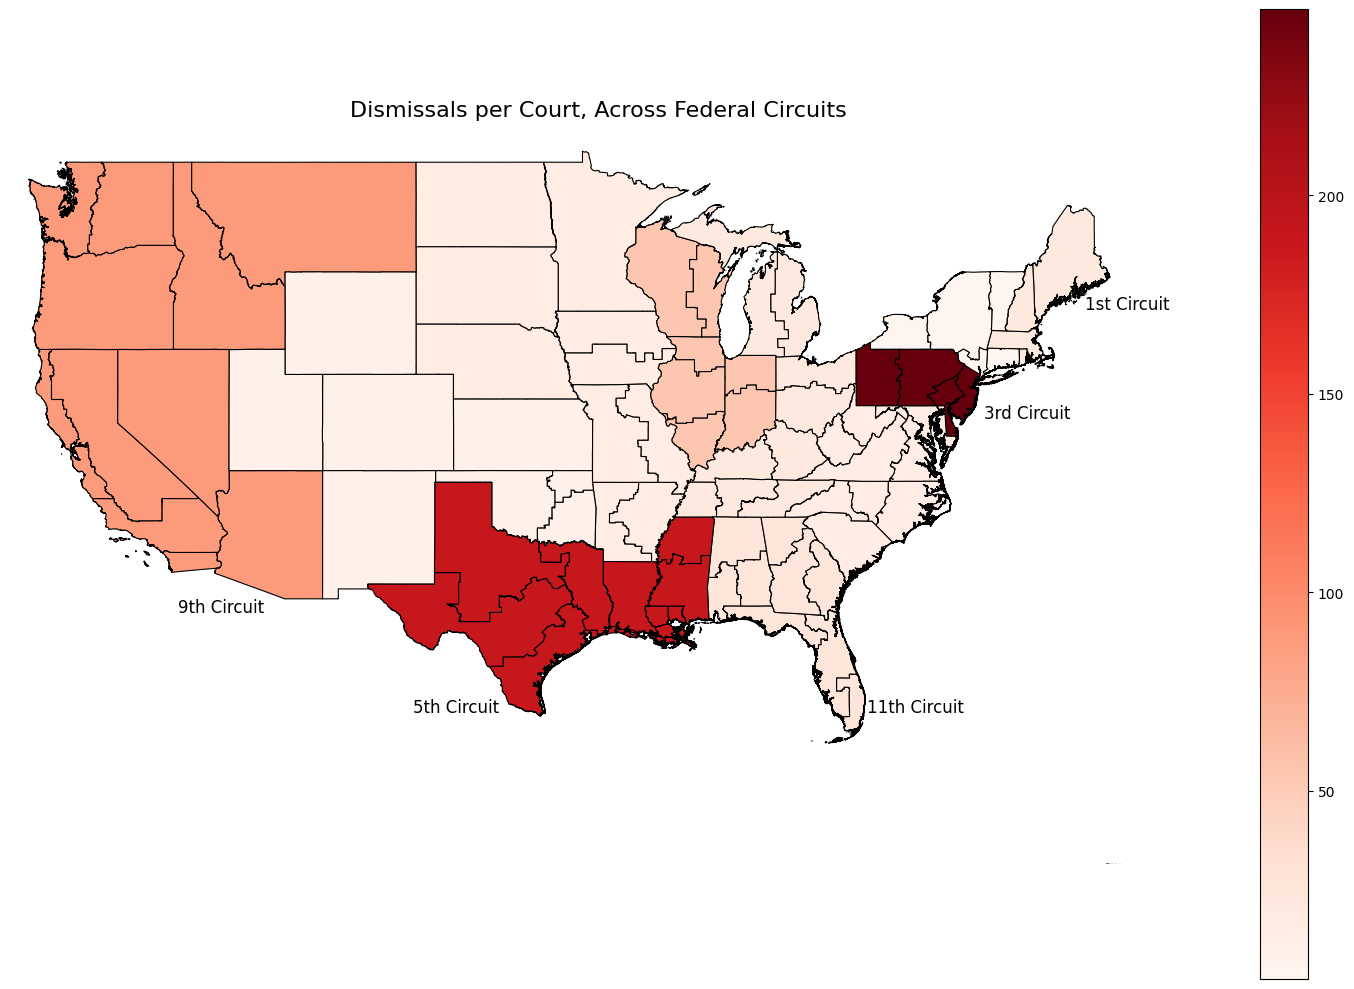

In [17]:
fig, ax = plt.subplots(figsize=(15, 10))

map_gdf.plot(column="dismissals_per_court",
             cmap="Reds",
             linewidth=0.8,
             edgecolor="black",
             legend=True,
             ax=ax)

ax.set_title("Dismissals per Court, Across Federal Circuits", fontsize=16)
ax.axis("off")  # Hide axis labels
ax.set_xlim([-1.4e7, -7e6])
ax.set_ylim([2.1e6, 6.5e6])

ax.annotate("5th Circuit", xy=(-1.16e7, 3e6), fontsize=12, color='black')
ax.annotate("11th Circuit", xy=(-0.89e7, 3e6), fontsize=12, color='black')
ax.annotate("9th Circuit", xy=(-1.3e7, 3.6e6), fontsize=12, color='black')
ax.annotate("1st Circuit", xy=(-0.76e7, 5.4e6), fontsize=12, color='black')
ax.annotate("3rd Circuit", xy=(-0.82e7, 4.75e6), fontsize=12, color='black')


plt.tight_layout()
plt.show()

This map shows the number of Dismissals per court. Interstingly, even though the 3rd circuit, previously did not appear to have a significant number of case filings per court, it has the highest concentration of dismissals. The 3rd circuit is followed by 5th, 9th, 11th and the 1st circuits.

The findings here, are mostly alligned with the map of filings per court, with the exception of the 3rd ciruit, emerging as the one with the highest concentraion of cases per court.

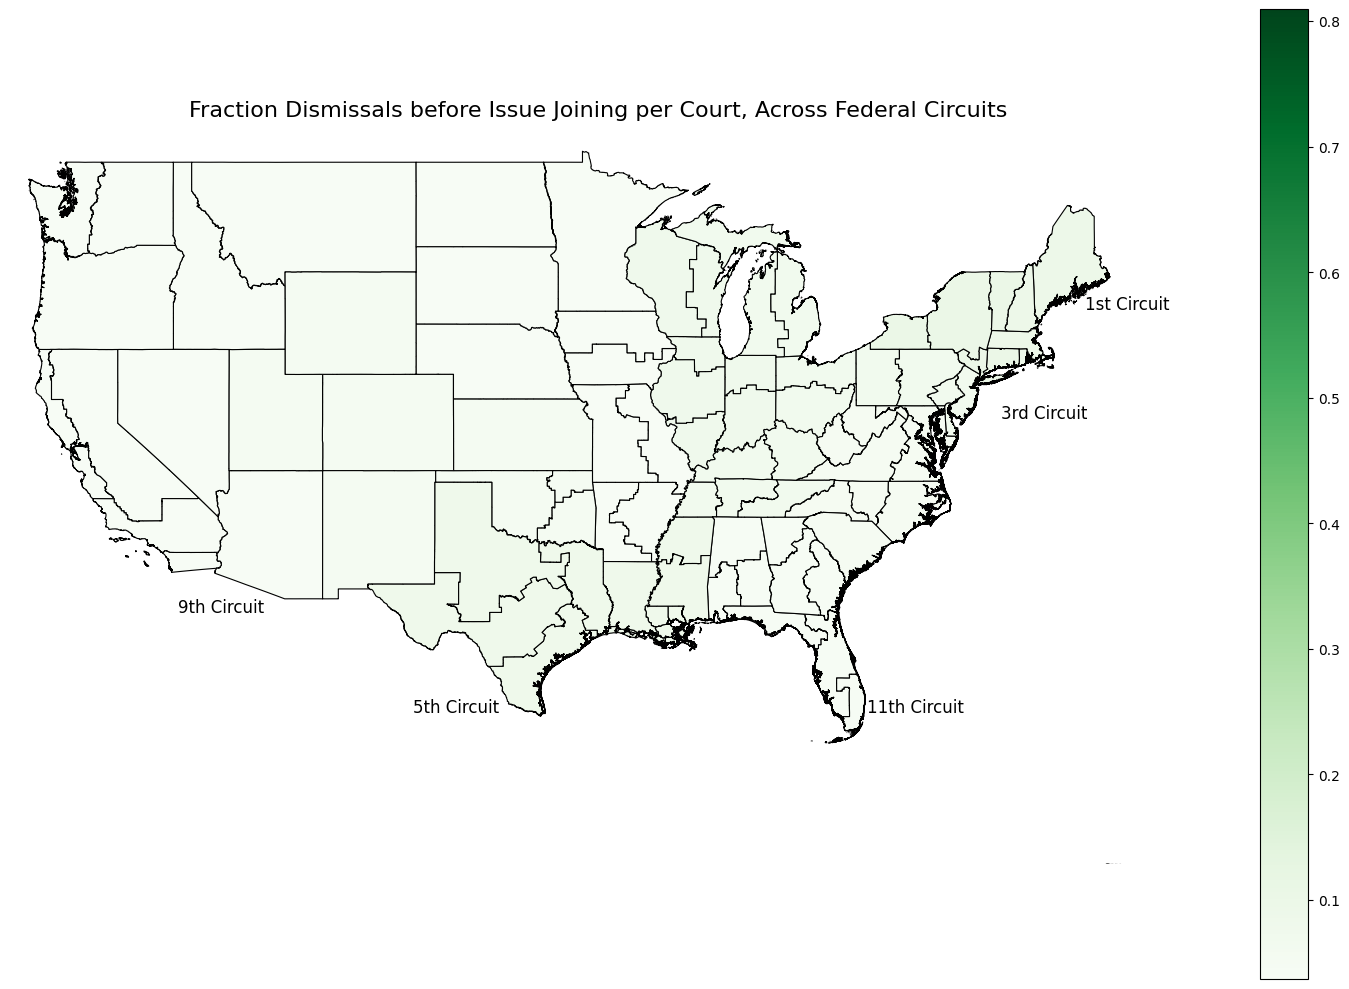

In [18]:
map_gdf['circuit_disp_issue_joined'] = map_gdf.groupby("Circuit")["disp_before_issue_joined"].transform('sum')
map_gdf['dismissals_before_issue'] = (map_gdf['circuit_disp_issue_joined']/map_gdf['circuit_dismissed'])/map_gdf['num_district_courts']

fig, ax = plt.subplots(figsize=(15, 10))

map_gdf.plot(column="dismissals_before_issue",
             cmap="Greens",
             linewidth=0.8,
             edgecolor="black",
             legend=True,
             ax=ax)

ax.set_title("Fraction Dismissals before Issue Joining per Court, Across Federal Circuits", fontsize=16)
ax.axis("off")  # Hide axis labels
ax.set_xlim([-1.4e7, -7e6])
ax.set_ylim([2.1e6, 6.5e6])

ax.annotate("5th Circuit", xy=(-1.16e7, 3e6), fontsize=12, color='black')
ax.annotate("11th Circuit", xy=(-0.89e7, 3e6), fontsize=12, color='black')
ax.annotate("9th Circuit", xy=(-1.3e7, 3.6e6), fontsize=12, color='black')
ax.annotate("1st Circuit", xy=(-0.76e7, 5.4e6), fontsize=12, color='black')
ax.annotate("3rd Circuit", xy=(-0.81e7, 4.75e6), fontsize=12, color='black')


plt.tight_layout()
plt.show()

This map shows the Fraction of Dismissals before issue joining, per court in each circuit. Isssue joining or issue joinder is a legal process where both parties in a lawsuit come together and agree upon which legal issues are being contested, in the case in question. Essentially cases that are dismissed before issue joinder are those that are withdrawn or dismissed, almost immediately after filing and likely before any major court action or proceedings have begun.


This map shows a very uniform geographical distribution, with no circuit appearing to have a significantly different rate of dismissals before issue joining per court.

# ***Section 7: Regressions:***

In [19]:
# Regression Table 1.1: The imapct of Case Disposals on Net Profit Margins[Defendents]

#base model
model1_d = smf.ols('delta_npm ~ disp_dismissed + disp_dismissed:disp_settled', data=subset_defendent_npm).fit()
#includes interactions
model2_d = smf.ols('delta_npm ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + disp_dismissed:disp_settled:disp_before_issue_joined', data=subset_defendent_npm).fit()
#includes interactions and case cause and length
model3_d = smf.ols('delta_npm ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + disp_dismissed:disp_settled:disp_before_issue_joined + infringement_35_271 + case_length', data=subset_defendent_npm).fit()
#includes interactions, case cause and GICS sector ficxed effects and case
model4_d = smf.ols('delta_npm ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + disp_dismissed:disp_settled:disp_before_issue_joined + infringement_35_271 + case_length + info_tech + health_care', data=subset_defendent_npm).fit()


#The imapct of Case Disposals on Net Profit Margins[Plaintiffs]

#based model
model1_p = smf.ols('delta_npm ~ disp_dismissed + disp_dismissed:disp_settled', data=subset_plaintiff_npm).fit()
#includes interactions
model2_p = smf.ols('delta_npm ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + disp_dismissed:disp_settled:disp_before_issue_joined', data=subset_plaintiff_npm).fit()
#includes interactions and case cause and length
model3_p = smf.ols('delta_npm ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + disp_dismissed:disp_settled:disp_before_issue_joined + infringement_35_271 + case_length', data=subset_plaintiff_npm).fit()
#includes interactions, case cause and GICS sector ficxed effects and case
model4_p = smf.ols('delta_npm ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + disp_dismissed:disp_settled:disp_before_issue_joined + infringement_35_271 + case_length + info_tech + health_care', data=subset_plaintiff_npm).fit()


#creating stargazer object
stargazer = Stargazer([model1_d, model2_d, model3_d, model4_d,
                       model1_p, model2_p, model3_p, model4_p])

# Custom column names
stargazer.custom_columns([
    "Defendant Model 1", "Defendant Model 2", "Defendant Model 3", "Defendant Model 4",
    "Plaintiff Model 1", "Plaintiff Model 2", "Plaintiff Model 3", "Plaintiff Model 4",
], [1, 1, 1, 1, 1, 1, 1, 1])

# Force variable order to match model specification
stargazer.covariate_order(["Intercept", "disp_dismissed", "disp_dismissed:disp_settled",
                            "disp_dismissed:disp_before_issue_joined",
                           "disp_dismissed:disp_settled:disp_before_issue_joined",
                           "infringement_35_271",
                            "case_length", "info_tech", "health_care"])

stargazer.rename_covariates({
    "disp_dismissed": "Case Dismissed",
    "disp_dismissed:disp_settled": "Dismissed:Settlement",
    "disp_dismissed:disp_before_issue_joined": "Dismissed:Before Issue Joined",
    "infringement_35_271": "Case Filed Under 35 U.S.C. § 271",
    "case_length": "log(time taken to cose case)",
    "info_tech": "Information Technology Sector(GICS)",
    "health_care": "Healthcare Sector(GICS)",
    "materials": "Materials Sector(GICS)",
    "industrials": "Industrials Sector(GICS)",
    "consumer_discretionary": "Consumer Discretionary Sector(GICS)",
    "disp_dismissed:disp_settled:disp_before_issue_joined":"Dismissed:Before Issue Joined:Settlement"})

stargazer.title("Esimated effect of Case Outcomes on Plaintiff Firms' Net Profit Margins")

# Display in Jupyter Notebook
display(HTML(stargazer.render_html()))


Model Specifications:
* Model1: delta_npm = Intercetpt + Case_Dismised + Case_Dismissed:Dismissed_with_Settlement

* Model2: delta_npm = Intercetpt + Case_Dismised + Case_Dismissed:Dismissed_with_Settlement + Case_Dismised:Dismissed_Before_Issue_Joined

* Model3: delta_npm = Intercetpt + Case_Dismised + Case_Dismissed:Dismissed_with_Settlement + Case_Dismised:Dismissed_Before_Issue_Joined + Filed_under_35:271 + log(days_taken)

* Model4: delta_npm = Intercetpt + Case_Dismised + Case_Dismissed*Dismissed_with_Settlement + Case_Dismised*Dismissed_Before_Issue_Joined + Filed_under_35:271 + log(days_taken) + Info_Tech + Health_Care

While it is possible to run regressions on the entire dataset and use a categorical variable to identify plaintiffs or defendents, we chose to run seperate regressions based on a number of factors. Chief among theses factors is the fact that there is class imbalance- there are almost thrice as many defendents as plaintiffs that have been identified as publicly listed firms from the full dataset, likely due to the fact that companies are often sued by individuals or smaller, non-publically listed firms. Furthermore, we expect to have systematic differences between outcomes for plaintiffs and defendents simply because they are on different sides of litigation, therefore, it is a lot more useful to learn the effects of dismissals on defendents, relative to other defendents (who do now have their cases dismissed, i.e. resolved via final judgment). The same is true for plaintiffs, the effect of dismissals on plaintiffs, relative to defendents is not very useful for inference about the economic impacts of litigation. Therefore, we run these regressions seperately.  

We do not include variables for firm size, as these data aren't available on compustat, except for the GICS sectors, that are included. While market capitalization could be a useful measure of firm size and explain some of systematic differences in size, we expect the volatality of stock prices, due to the lawsuit, to pollute this indicator of firm size. When being sued, market caps will likely be understated due to droppiing stock prices. Furthermore, market cap data isn't available uniformly for each form in the relavent time period, because all of the firms in our dataset we're listed/removed from different exchanges at differnt times. Thus, adding in market cap or stock price as a mmeasure would also lead to loss of observations.

Models 1 to 3 are all subsets of model 4, with R-squarred and Adj. R-squarred values, we observe that model 4 is the best, in terms of explainging variance in the outcome variables. We also note that since the outcome variables are differences in a percent points(on the scale of 0.01 = 1 percent point), our Betas are also part of the same scale of percent point differences, which makes interpretation convenient.

The first regression table shows the results of litigation impacts on Net Profit Margins for Defendants and Plaintiffs. While a lot of the coefficients and F-statistics appear to not be statistically significant, there are some very interesting key findings.

For the defendants we observe that Case Dismissals, as opposed to a full fledged legal battle ended by a final judgment, on average are associated with a 46 perecentage point decrease in Profit Margins(holding constant covariates), significant at the 95% confidennce level. This is surprising as the general intuition regarding dismissals is that they save firms money, by avoiding expensive, longterm litigation. We also observe that the dismissals through settlements, have a positive interaction effect of 30 percentage point increase, which brings the net effect to about a 16 percentage point decrease in Profit Margins(holding constant covariates), significant at the 90% level. This alligns with intuition as settlements are likely to be sealed from public records and have stipulations that give the defendants certain protections like safety from being sued again over the same issue, thus settlements are observed to be mitigating some of the negative impact of dismissals. In addition, we observe that firms in the Information Technology sector are specifically are observed to have about a 49 percentage point decrease in Net Profit Margins(holding constant covariates), after being sued for patent related matters. This is significant at the 90% confidence level. When the case goes to judgment the net effect is still 49 percentage points, but with dismissals, the net effect becomes a 95 percentage point decrease in Profit Margins, which is also really surp

For the Plaintiffs, we find a highly surprising surge Profit Margings of firms that have their cases dismissed before issue joining. On avearge, these plaintiff firms have a 4000 percentage points increase in Profit Margins(holding constant covariates), this is also significant at 99% level. This is extremely surpising for two reasons; the first being the size of the effect and the second being the direction. A 4000 percent point increase is simply mind boggling, especially considering the fact, that the general intuition about dismissals is that they facour defendants. While it is possible that dismissals can include settlements or other agreements that are favourable to plaintiffs, it is still amazing to see that they are observed with such extreme surges in profits.Additionally, we find that firms in the healthcare sector, specicifally, are observed to have 3500 percentage point increase in profits,significant at the 9, when cases go the judgement. With dismissals, the net effect is 7500 percentage point increase profit margins, which is really surprising.

In [20]:
# Regression Table 2.1: The imapct of Case Disposals on RnD-Sales Ratio[Defendent]

#base model
model1_d = smf.ols('delta_rnd_sales ~ disp_dismissed + disp_dismissed:disp_settled', data=subset_defendent_RnD).fit()
#includes interactions
model2_d = smf.ols('delta_rnd_sales ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + disp_dismissed:disp_settled:disp_before_issue_joined', data=subset_defendent_RnD).fit()
#includes interactions and case cause
model3_d = smf.ols('delta_rnd_sales ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + disp_dismissed:disp_settled:disp_before_issue_joined + infringement_35_271 + case_length', data=subset_defendent_RnD).fit()
#includes interactions, case cause and GICS sector ficxed effects and case
model4_d = smf.ols('delta_rnd_sales ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + disp_dismissed:disp_settled:disp_before_issue_joined + infringement_35_271 + case_length + info_tech + health_care', data=subset_defendent_RnD).fit()


# Regression Table 2.2: The imapct of Case Disposals on RnD-Sales Ratio[Plaintiffs]

#based model
model1_p = smf.ols('delta_rnd_sales ~ disp_dismissed + disp_dismissed:disp_settled', data=subset_plaintiff_RnD).fit()
#includes interactions
model2_p = smf.ols('delta_rnd_sales ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + disp_dismissed:disp_settled:disp_before_issue_joined', data=subset_plaintiff_RnD).fit()
#includes interactions and case cause
model3_p = smf.ols('delta_rnd_sales ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + disp_dismissed:disp_settled:disp_before_issue_joined + infringement_35_271 + case_length', data=subset_plaintiff_RnD).fit()
#includes interactions, case cause and GICS sector ficxed effects and case
model4_p = smf.ols('delta_rnd_sales ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + disp_dismissed:disp_settled:disp_before_issue_joined + infringement_35_271 + case_length + info_tech + health_care', data=subset_plaintiff_RnD).fit()


#creating stargazer object
stargazer = Stargazer([model1_d, model2_d, model3_d, model4_d,
                       model1_p, model2_p, model3_p, model4_p])

# Custom column names
stargazer.custom_columns([
    "Defendant Model 1", "Defendant Model 2", "Defendant Model 3", "Defendant Model 4",
    "Plaintiff Model 1", "Plaintiff Model 2", "Plaintiff Model 3", "Plaintiff Model 4",
], [1, 1, 1, 1, 1, 1, 1, 1])

# Force variable order to match model specification
stargazer.covariate_order(["Intercept", "disp_dismissed", "disp_dismissed:disp_settled",
                            "disp_dismissed:disp_before_issue_joined",
                            "disp_dismissed:disp_settled:disp_before_issue_joined",
                           "infringement_35_271",
                            "case_length",  "info_tech", "health_care"])

stargazer.rename_covariates({
    "disp_dismissed": "Case Dismissed",
    "disp_dismissed:disp_settled": "Dismissed:Settlement",
    "disp_dismissed:disp_before_issue_joined": "Dismissed:Before Issue Joined",
    "infringement_35_271": "Case Filed Under 35 U.S.C. § 271",
    "case_length": "log(time taken to cose case)",
    "info_tech": "Information Technology Sector(GICS)",
    "health_care": "Healthcare Sector(GICS)",
    "materials": "Materials Sector(GICS)",
    "industrials": "Industrials Sector(GICS)",
    "consumer_discretionary": "Consumer Discretionary Sector(GICS)",
    "disp_dismissed:disp_settled:disp_before_issue_joined":"Dismissed:Before Issue Joined:Settlement"})

stargazer.title("Esimated effect of Case Outcomes on Plaintiff Firms' Change in R&D to Sales Ratio")

# Display in Jupyter Notebook
display(HTML(stargazer.render_html()))

The second Regression table has the same model specifications, with the only difference being the difference in R&D to sales ratio is the outcome variable. Overall, most of the estimated coefficients appear to be statistically insignificant with the exception info-tech defendants and healthcare plaintiffs.

For Info-Tech defendants, we observe 7.7 percentage point increase in R&D investment for firms in the info-tech sector, significant at the 90% level. This is surprising, as it suggests that being sued encourages investment in research. Since our outcome variable is computed by taking the difference of the R&D to sales ratio at the time case closing and the ratio at the time of case filing, positive coefficient suggests, that tech firms are observed to invest more in reserch, on average,  after being sued.

For Healthcare Plaintiffs, we observe a massive 1100 percentage point drop in research investment for plaintiffs, significant at the 90% level. This is also really counterituitive as it suggests the suing another firm makes the plaintiff disincitivized to invest in research, which if true, is a significant negative externality to society.

Needless to say, all estiamted effects between the two regression tables are simply observed realtionships and not causal in nature. Any number of observable or latent factors could be influencing these factors, thus futher work on valid causal inference would be key, with regards to better understanding the impact of litigation outcomes.

# ***Section 8: Web Scraping***




***How Web-Scraping can Enhance our Research:***
In order to enhance the regression models, it would be useful to have more data about the specific patents involved in each of the cases, as this information could help capture similarities and differences between cases, based on what type of intellectual property product is under legal scrutiny. This can significantly impact the results of our base regressions and therefore, are highlly significant to the research. To get these data, we attempt to web scrape google patents using the patent numbers included in the patents.csv file from the original kaggle dataset. Web-Scraping is warranted in this instance due to large number of unique webpages we must access to get data for all of the unique patent numbers in our data (about 4,400).

***Website and Data Chosen for Scraping:***
We use html based web-scraping to get variables related to patents from https://patents.google.com/. Specifically we aim to extract eight different pieces of informataion-

1.   Title of Patent
2.   Filing Date
3.   Issue Data
4.   Assignee of the Patent
5.   Text Abstract detailing information about the invention and its use
6.   The number of citations the given patent has, in related research
7.   Classification or the category that the patent falls under, as per the USTPO
8.   The Claim count, which measures how many different legal protections the given patent is protected under, legally

***Proposed Merging Strategy:***
Some of the expected challenges on this includem, but aren't limited to- computational cost due to large number of patents, scraping about 4,400 unique webpages on google patents for each unique patent and dealing with failed requests.

***Challenges with Scraping:***
Since there are about 4400 unique patent numbers in our dataset, we use the asybcio library to fetch multiple patents at the same time, for efficient scraping. Post scraping the data could be merged with the main dataset through the patent numbers which are linked to case numbers and thus unique cases in our data.

In [21]:
#loading up patents.csv and adding patent column to existing dfs
patents = pd.read_csv("/content/drive/My Drive/ECO225_Final_Project/DATA/patents.csv")
defendents_complete = defendents_complete.merge(patents[['case_number', 'patent']], on='case_number', how ='left')
plaintiffs_complete = plaintiffs_complete.merge(patents[['case_number', 'patent']], on='case_number', how ='left')

In [22]:
#Web-Scraping Code- Comments explain the function of each part
import nest_asyncio
nest_asyncio.apply()

import asyncio
import aiohttp
from bs4 import BeautifulSoup
import time
import logging
logging.getLogger("asyncio").setLevel(logging.CRITICAL)


#This first part of the code defines a function to fetch the html code for each
#webpage corresponding to a patent in our data
async def fetch(session, url):  # async allows the functions to pause and resume
    headers = {"User-Agent": "Mozilla/5.0 (compatible; PatentScraper/1.0)"}
    try:
        async with session.get(url, headers=headers) as response:
            if response.status == 200:
                return await response.text() #returns the response from the webpage
            else:
                return None #returns none if request has failed
    except Exception as e:
        return None #returns none if exception occurs

#this function takes in the patent numbers creates the relavent link to a google
#patents web page corresponding to each unique patent in the data
async def scrape_patent_info(session, patent_number):
    url = f"https://patents.google.com/patent/US{patent_number}/en"
    html = await fetch(session, url)
    if not html:
        return None #return none when the function doesn't receive response

    #a beautiful soup object is created to sort the raw html data received
    soup = BeautifulSoup(html, 'html.parser')

    # Extract Patent Title
    title_tag = soup.find("meta", {"name": "DC.title"})
    title = title_tag.get("content") if title_tag else None

    # Extract Filing Date
    filing_date_tag = soup.find("meta", {"scheme": "patent.filing_date"})
    filing_date = filing_date_tag.get("content") if filing_date_tag else None

    # Extract Issue Date
    issue_date_tag = soup.find("meta", {"scheme": "patent.issue_date"})
    issue_date = issue_date_tag.get("content") if issue_date_tag else None

    # Extract Assignee
    assignee_tag = soup.find("meta", {"scheme": "patent.assignee"})
    assignee = assignee_tag.get("content") if assignee_tag else None

    # Extract Abstract text (if available)
    abstract_section = soup.find("div", {"class": "abstract"})
    abstract = abstract_section.get_text(separator=" ", strip=True) if abstract_section else None

    # Extract Citation Count (example method)
    cited_by_section = soup.find("section", {"itemprop": "citedBy"})
    if cited_by_section:
        cited_by_count = len(cited_by_section.find_all("tr"))
    else:
        cited_by_count = None

    # Extract Classification Codes
    classification_tag = soup.find("dd", {"itemprop": "ipcSection"})
    classification = classification_tag.get_text(separator=" ", strip=True) if classification_tag else None

    # Extract Claim Count (if provided)
    claim_tag = soup.find("meta", {"name": "DC.relation.claimCount"})
    claim_count = claim_tag.get("content") if claim_tag else None

    #if the tags fall into none of the 8 specied categories they are all set to none

    return {
        "patent_number": patent_number,
        "title": title,
        "filing_date": filing_date,
        "issue_date": issue_date,
        "assignee": assignee,
        "abstract": abstract,
        "cited_by_count": cited_by_count,
        "classification": classification,
        "claim_count": claim_count
    } #returns a dictionary of the 8 variables of interest

async def main(patent_numbers): #this is the main function which runs the first two for all patent numbers in our data
    results = []
    # Limits simultaneous connections to avoid overwhelming the target server
    connector = aiohttp.TCPConnector(limit=100)
    async with aiohttp.ClientSession(connector=connector) as session:
        tasks = [asyncio.create_task(scrape_patent_info(session, num)) for num in patent_numbers]
        responses = await asyncio.gather(*tasks)
        results = [r for r in responses if r is not None]
    return results

#isolating unique patent numbers into a list
patent_numbers = list(set(plaintiffs_complete['patent'].dropna()).union(set(defendents_complete['patent'].dropna())))

#applying the web scraping functions and collecting the responses
scraped_data = await main(patent_numbers)

#converting rewsponses into a Data Frame object
scraped_df = pd.DataFrame(scraped_data)

In [23]:
scraped_df

,patent_number,title,filing_date,issue_date,assignee,abstract,cited_by_count,classification,claim_count
0,6624761,Content independent data compression method an...,None,None,None,Systems and methods for providing fast and eff...,None,None,None
1,8437797,Wireless image distribution system and method ...,None,None,None,A system and method for distributing at least ...,None,None,None
2,6373188,Efficient solid-state light emitting device wi...,None,None,None,A more efficient solid-state light emitting de...,None,None,None
3,5975893,Method and system for incrementally moving tee...,None,None,None,A system for repositioning teeth comprises a p...,None,None,None
4,6970183,Multimedia surveillance and monitoring system ...,None,None,None,"A comprehensive, wireless multimedia surveilla...",None,None,None
...,...,...,...,...,...,...,...,...,...
252,6275166,RF remote appliance control/monitoring system ...,None,None,None,A system for managing a distributed array of a...,None,None,None
253,6556905,Vehicle supervision and monitoring \n,None,None,None,Vehicle monitoring arrangement tracks and reco...,None,None,None
254,7872072,Branched polymers and their conjugates \n,None,None,None,The present invention is directed to branched ...,None,None,None
255,5548637,Method and apparatus for locating personnel an...,None,None,None,An automated position location system is provi...,None,None,None


In [24]:
scraped_df.isna().sum()

,0
patent_number,0
title,0
filing_date,257
issue_date,257
assignee,257
abstract,3
cited_by_count,257
classification,257
claim_count,257


In [25]:
# Re-enable printing after the scraping process
print("Could only scrape", len(scraped_df), 'pages but the data has',
      len(patent_numbers), 'unique patent numbers')

Could only scrape 257 pages but the data has 4470 unique patent numbers


Based on the dataframe displayed above, our scraping function only yielded 294 rows out of 4,400. Additionally, all of the searched variables except for title and abstract had all missing values. This was dissapointing, as the vast majority about 93% of the fetch attempts failed, even though many of the url's were valid, as confirmed by manual checking. Many of these pages may have yet been missing or non-existent, this combined with the fact that inconsistencies in HTML structures between all of these individual web pages are likely the main factors behind the failure of the scraping functions. The text data from the abstracts is visualized below with a word cloud and a bar-chart visualizing the frequency of different words, that maybe indiciative of the nature/industry of the underlying invention for the coresponding patent.

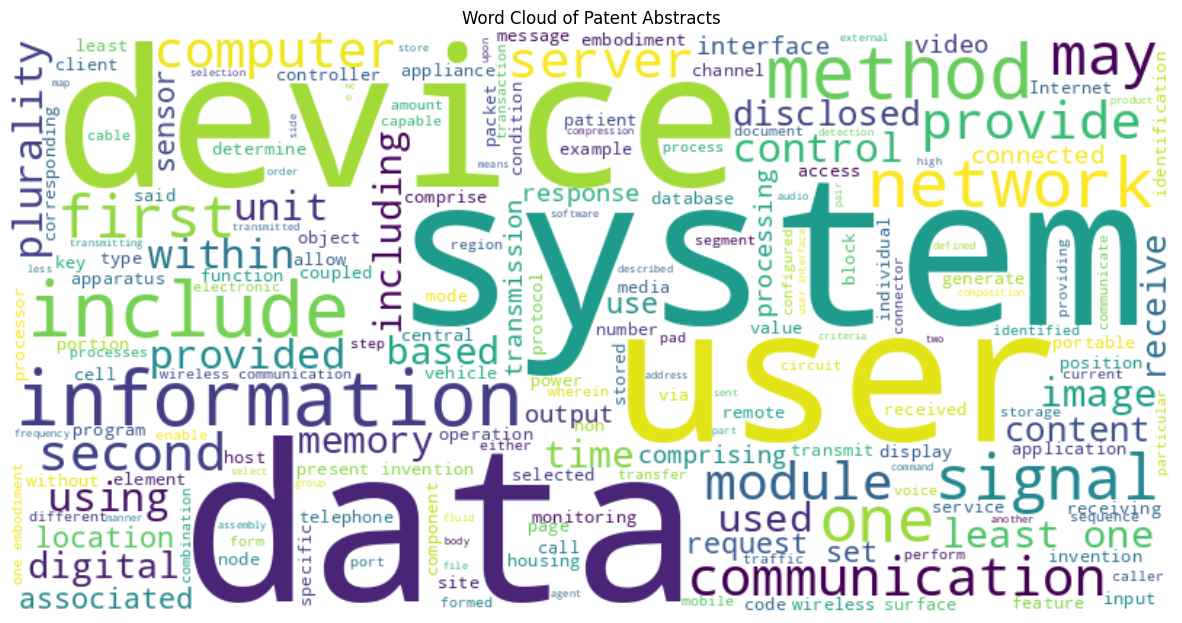

In [26]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# Assume scraped_df is already loaded with a column "abstract"

# Generate Word Cloud
all_text = " ".join(scraped_df["abstract"].dropna())
wc = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(15, 10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Patent Abstracts")
plt.show()

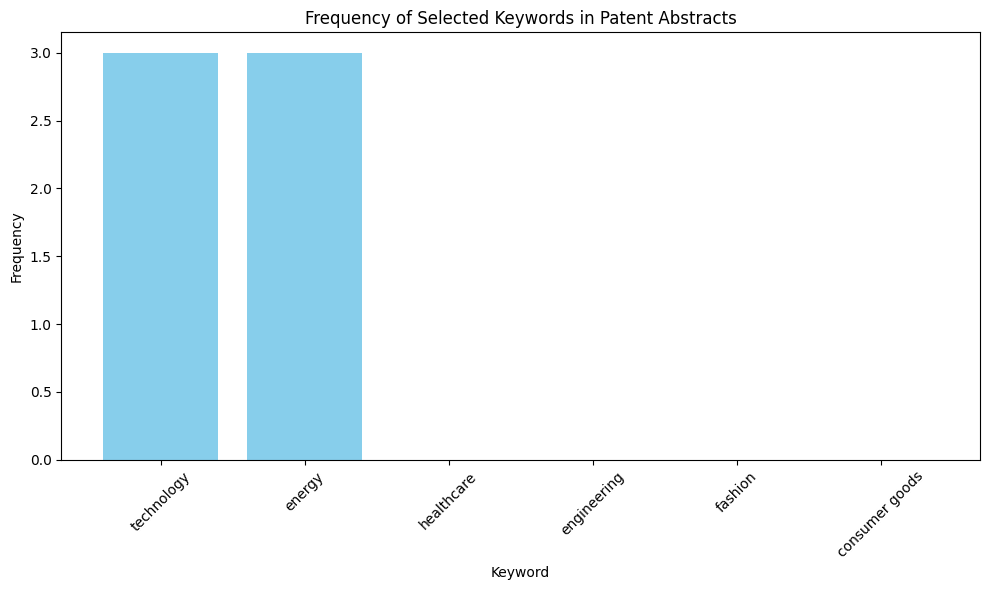

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume scraped_df is already loaded with a column "abstract"
keywords = ["technology", "healthcare", "engineering", "fashion", "consumer goods", "energy"]

# Count occurrences of each keyword in all abstracts (case-insensitive)
frequency = {word: scraped_df["abstract"].str.lower().str.count(word).sum() for word in keywords}

# Create a DataFrame for plotting and sort by frequency
freq_df = pd.DataFrame(list(frequency.items()), columns=["Keyword", "Frequency"]).sort_values("Frequency", ascending=False)

# Plot a bar chart
plt.figure(figsize=(10, 6))
plt.bar(freq_df["Keyword"], freq_df["Frequency"], color='skyblue')
plt.xlabel("Keyword")
plt.ylabel("Frequency")
plt.title("Frequency of Selected Keywords in Patent Abstracts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The word cloud and bar chart themselves, aren't very informative and cannot be effectively combined with the tabular data. Furtermore, merging the data would imply that we lose 97% of our observations, which makes it impractical entirely.Had the scraping worked as intended, we could have merged the tabular variables with the main data and performed text analysis on the abstracts. Our intendend course of action was to build a tv-idf matrix of relavent and frequently occuring tokens or collocations and then compute a cosine simlarity matrix for all patents in our data. This would yield us key insights into which cases are most similar to each other, with regards to the intellectual property product that is under contenttion in the case, which could help us add more fixed effects for cases involving IPs of similar type and quality. Unfortunately this wasn't feasible due to the exceptionally small sample of the scraped data.

Given the focus of this paper on patent litigations, it is also inherantly difficult use scraped data. This is due to the fact that case details are usually only available to the public, for research or other purposes, through the Public Access to Court Electronic Records(PACER), which is not a free source and charges a substantial fee. Similarly the USTPO (Trademark and Patents Office) also has limtied public access to data about specific patents. Thus, the nature of this research is not conducive to a web-scraping approach.

# ***Section 9: Machine Learing***

We now fit Regression Tree and Random Forrest algorithms to our data, to contrast their performance against the OLS models' performance. We also focus on whether the most important predictors with ML algorithms differ from the statistically significant coefficients from our regression models. We will be applying the regression tree, first two both our outcome variables(delta_npm and delta_rnd_sales) with just the variables used in our regressions. Then, we apply the tree to both outcome variables, with many variables omitted from our regressions for multi-collinearity or relavence concerns. Finally, we fit a random forrests model and use the feature importance matrix to infer which variables are important for predicting each of our outcome variables.

In [28]:
complete_data = pd.concat([plaintiffs_complete, defendents_complete], axis=0)
complete_data = complete_data.drop(columns=['case_number','date_filed','patent',
                                            'PLT'])

complete_data['DEF'] = complete_data['DEF'].notna().astype(int)

In [29]:
complete_data

,delta_npm,delta_rnd_sales,disp_dismissed,disp_settled,disp_before_issue_joined,infringement_35_271,disp_judgment,judgment_monetary_award,judgment_injunction,judgment_ordered_loss,judgment_for_defendent,jury_demand_defendent,jury_demand_both,case_length,info_tech,health_care,materials,consumer_discretionary,DEF
0,-0.056082,0.009418,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,6.588926,0.0,0.0,0.0,0.0,0
1,-0.061502,0.005320,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,4.595120,1.0,0.0,0.0,0.0,0
2,-0.008659,0.017003,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,5.225747,0.0,1.0,0.0,0.0,0
3,-0.011065,-0.003862,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,7.451242,0.0,0.0,1.0,0.0,0
4,0.000061,-0.000474,1.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4.025352,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5454,0.332866,-0.004756,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.218600,0.0,0.0,0.0,0.0,1
5455,-0.011602,0.003026,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.484635,0.0,0.0,0.0,0.0,1
5456,-0.011602,0.003026,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.484635,0.0,0.0,0.0,0.0,1
5457,0.005629,0.009647,1.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,6.786717,0.0,1.0,0.0,0.0,1


The objective function of the Regression Trees algorithm is:

**Regression RSS:**  
$$
\sum_{m=1}^{|T|} \sum_{i \in R_j} (y_i - \hat{y}_{R_m})^2 + \alpha |T|
$$

This function represents the total loss or residual for the entire tree, by summing over the residuals at each node in the tree. Minimizing this total loss yields the optimal configuration of the tree which fits the data, most accurately. However, if left unchecked trees will simply grow in depth until they essentially learn the data, or in other words, overfit heavily by learning the noise in the data along with useful, generalizable patterns. Therefore, we add the regularization term denoted by the alpha * absolute_value(T). This term effectively penalizes overly complex trees by directly adding the number of nodes(T) into the objective function that is minimized by python, at the time of fitting the tree to data. Thus, the regularization term effectively protects against overfitting and ensures, that the model is generalizable to data not used in training the model.

In [30]:
#Running Regression Trees with same predictors as OLS, on both Y-variables
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score

# non-NaN dataset
complete_data = complete_data[complete_data['delta_npm'].notna()]

# Features and target
X_npm = complete_data[['disp_dismissed', 'disp_settled',
                      'disp_before_issue_joined', 'infringement_35_271',
                      'case_length', 'info_tech', 'health_care']]
y_npm = complete_data['delta_npm']

X_rnd = complete_data[['disp_dismissed', 'disp_settled',
                      'disp_before_issue_joined', 'infringement_35_271',
                      'case_length', 'info_tech', 'health_care']]
y_rnd = complete_data['delta_rnd_sales']

# Initialize and train model
npm_regtree = DecisionTreeRegressor(random_state=42, max_depth=5)
npm_regtree.fit(X_npm, y_npm)

rnd_regtree = DecisionTreeRegressor(random_state=42, max_depth=5)
rnd_regtree.fit(X_rnd, y_rnd)


# Predict and evaluate
y_pred_npm = npm_regtree.predict(X_npm)
mse_npm = mean_squared_error(y_npm, y_pred_npm)
r2_npm = r2_score(y_npm, y_pred_npm)

y_pred_rnd = npm_regtree.predict(X_rnd)
mse_rnd = mean_squared_error(y_rnd, y_pred_rnd)
r2_rnd = r2_score(y_npm, y_pred_npm)


print("Mean Squared Error (NPM):", mse_npm)
print("R-Squarred (NPM):", r2_npm)
print("Mean Squared Error (R&D)):", mse_rnd)
print("R-Squarred (R&D):", r2_rnd)

Mean Squared Error (NPM): 50.326081040546306
R-Squarred (NPM): 0.9966201592173161
Mean Squared Error (R&D)): 27280.339229190573
R-Squarred (R&D): 0.9966201592173161


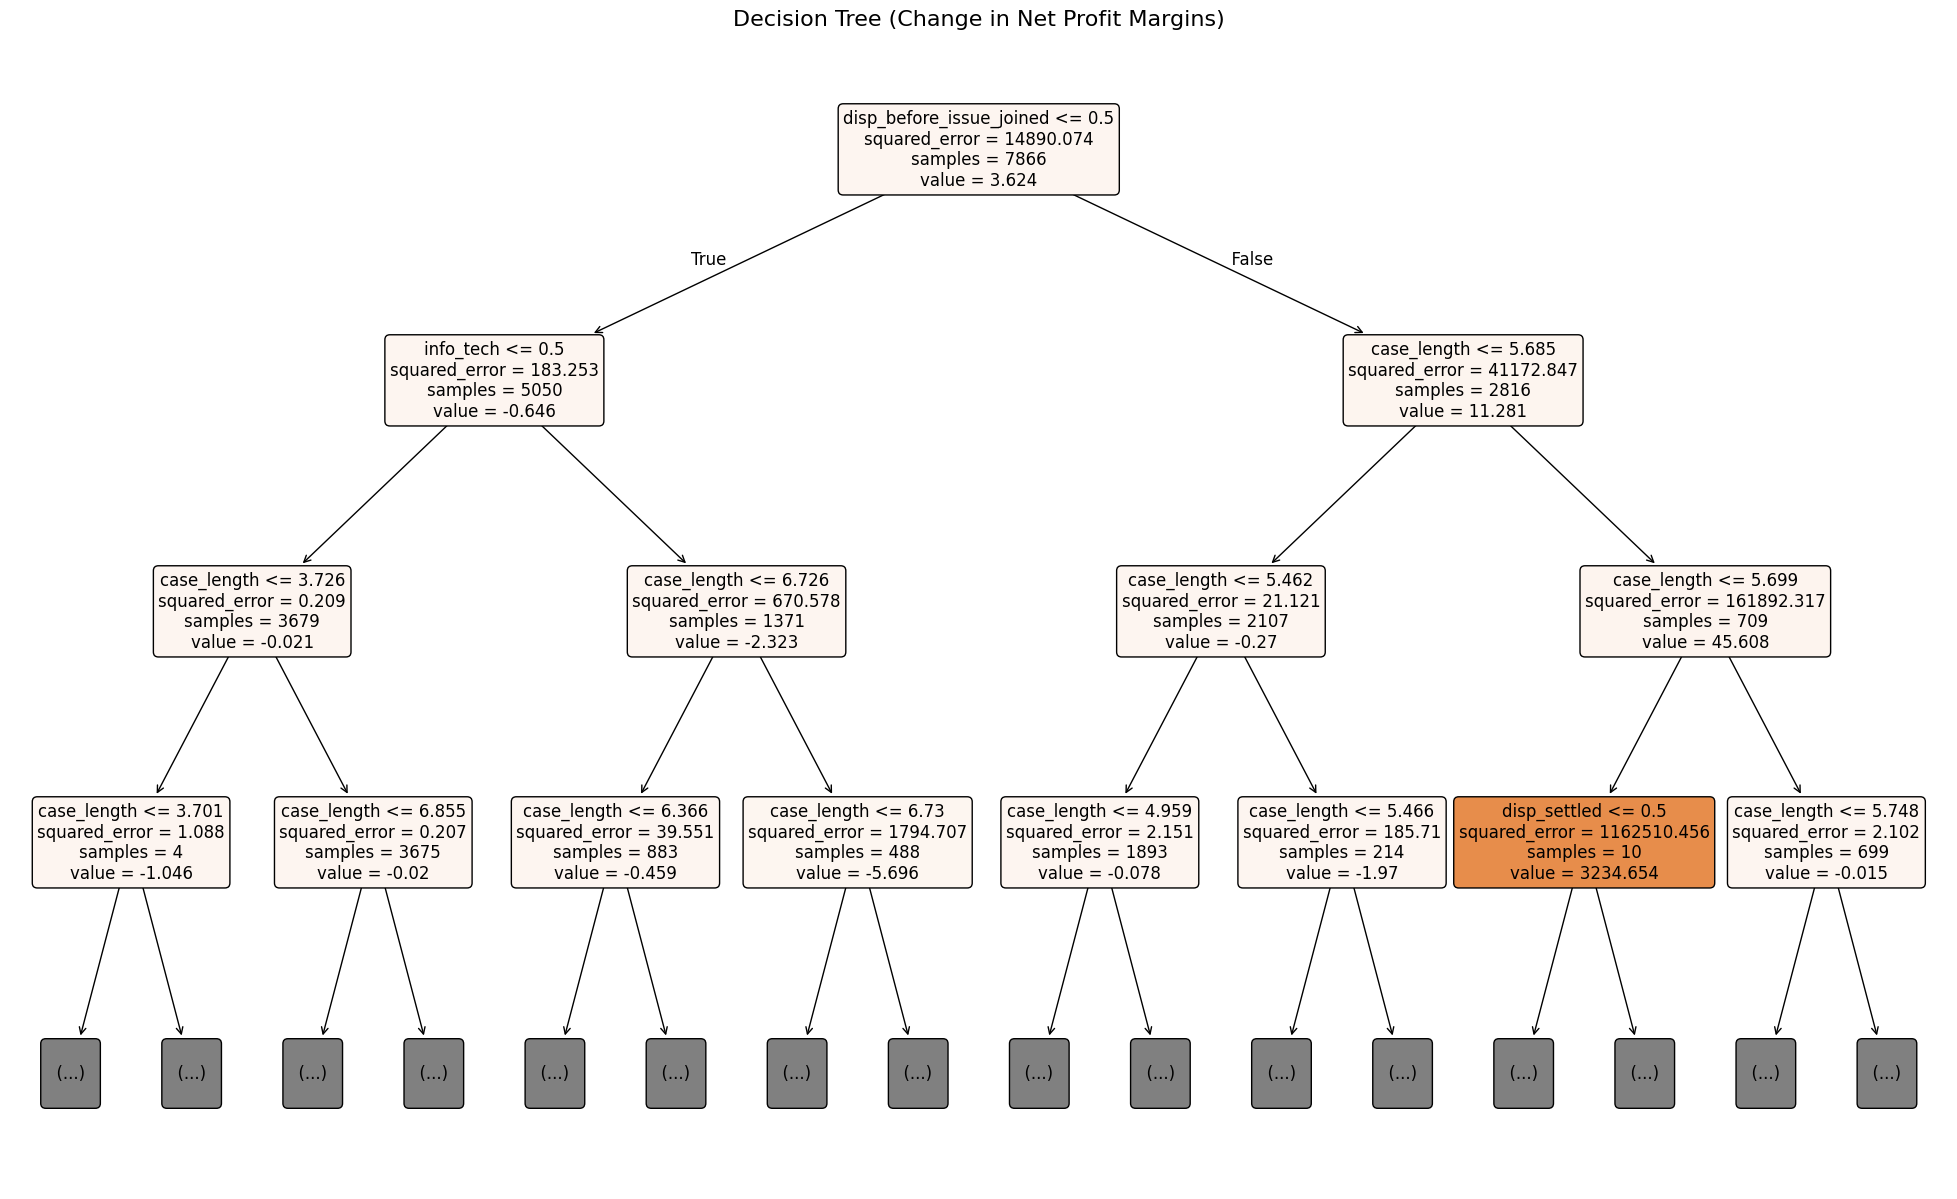

In [31]:
# Plot the decision tree with limited depth for visualization
plt.figure(figsize=(25, 15))  # You can adjust the figure size too
plot_tree(
    npm_regtree,
    feature_names=X_npm.columns,
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=12 )
plt.title("Decision Tree (Change in Net Profit Margins)", fontsize=16)
plt.show()

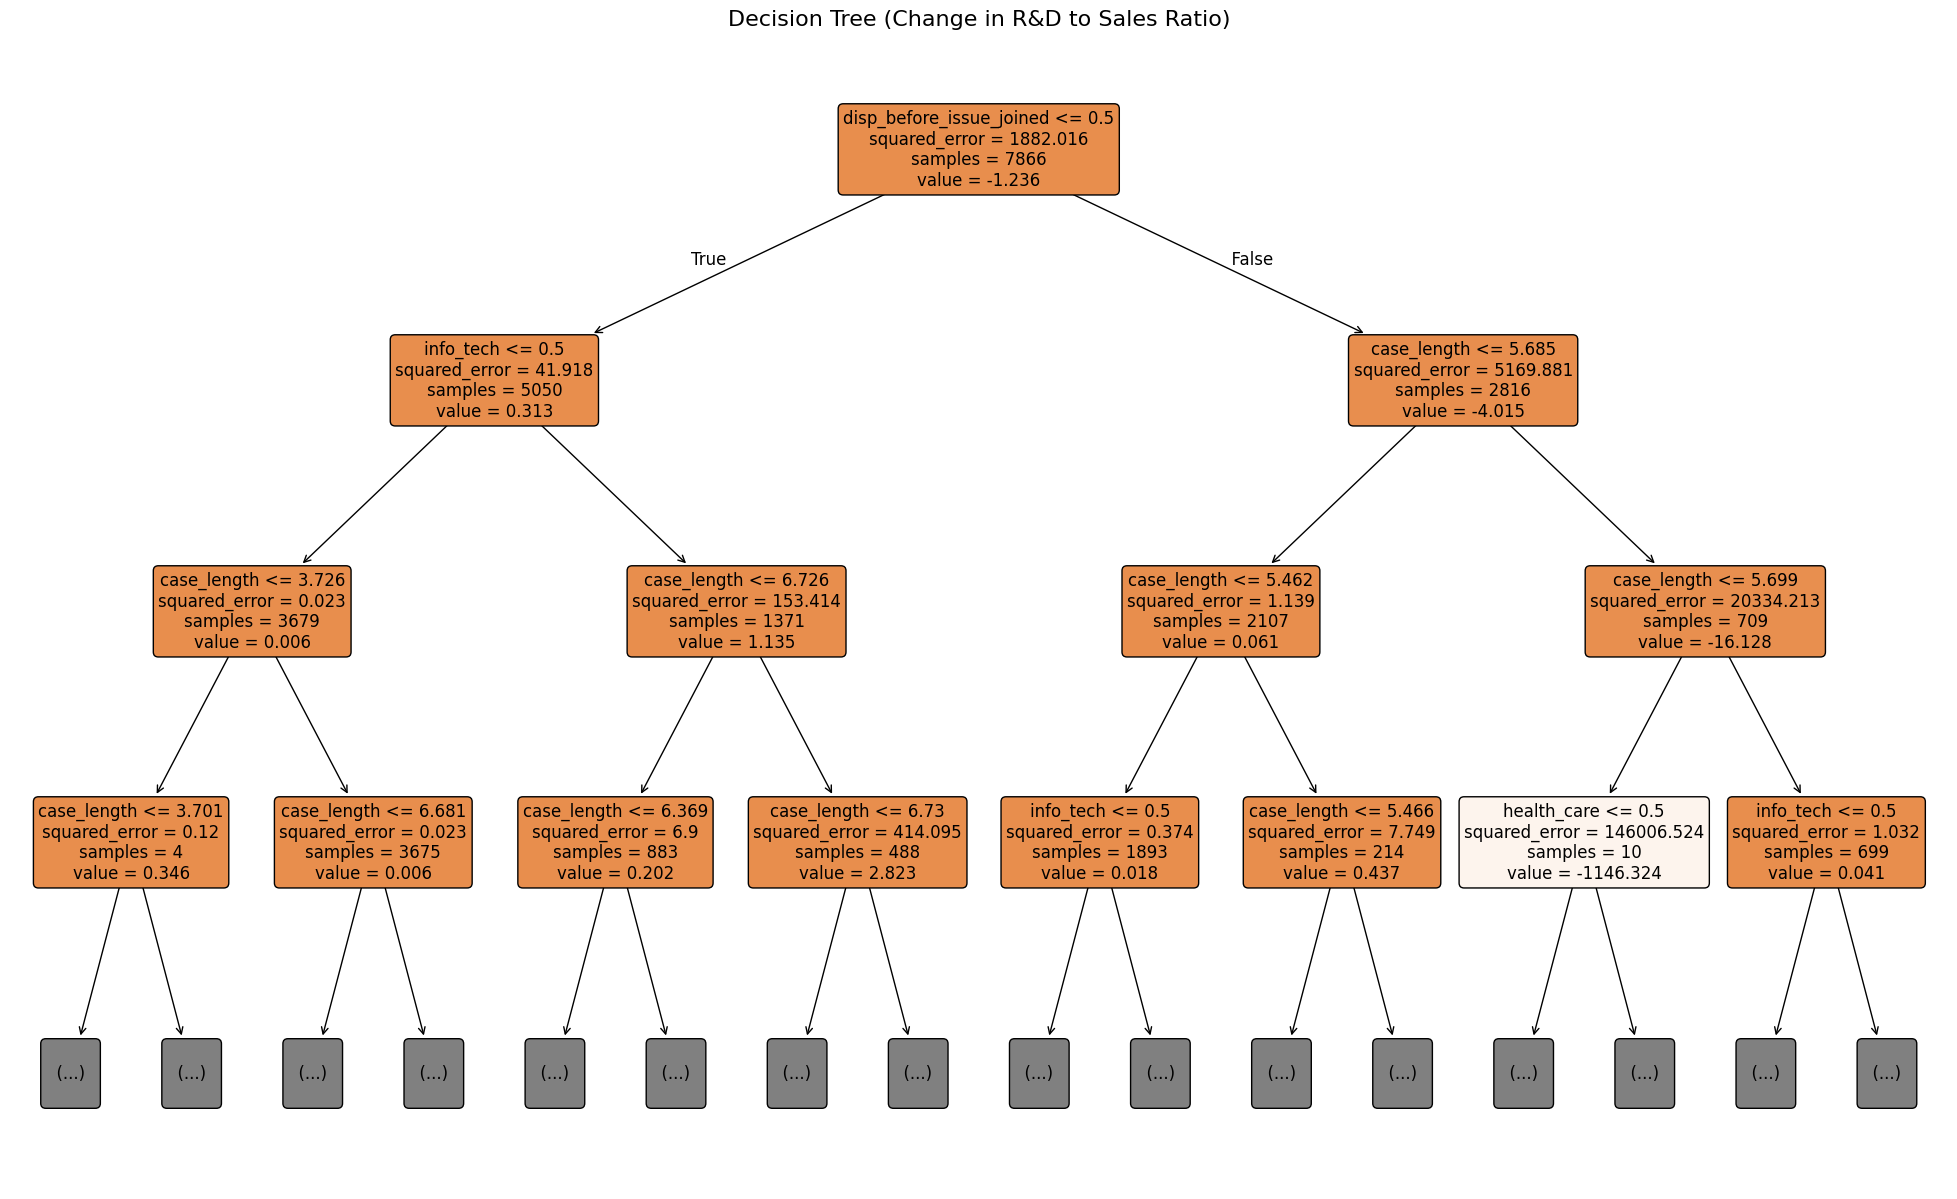

In [32]:
plt.figure(figsize=(25, 15))  # You can adjust the figure size too
plot_tree(
    rnd_regtree,
    feature_names=X_npm.columns,
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=12 )
plt.title("Decision Tree (Change in R&D to Sales Ratio)", fontsize=16)
plt.show()

In [39]:
#Running Regression Trees with all Xs
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score

# non-NaN dataset
complete_data = complete_data[complete_data['delta_npm'].notna()]

# Features and target
X_npm = complete_data[list(col for col in complete_data.columns if col not in ['delta_npm', 'delta_rnd_sales'])]
y_npm = complete_data['delta_npm']

X_rnd = complete_data[list(col for col in complete_data.columns if col not in ['delta_npm', 'delta_rnd_sales'])]
y_rnd = complete_data['delta_rnd_sales']

npm_regtree = DecisionTreeRegressor(random_state=42, max_depth=5)
npm_regtree.fit(X_npm, y_npm)

rnd_regtree = DecisionTreeRegressor(random_state=42, max_depth=5)
rnd_regtree.fit(X_rnd, y_rnd)

# Predict and evaluate
y_pred_npm = npm_regtree.predict(X_npm)
mse_npm = mean_squared_error(y_npm, y_pred_npm)
r2_npm = r2_score(y_npm, y_pred_npm)

y_pred_rnd = npm_regtree.predict(X_rnd)
mse_rnd = mean_squared_error(y_rnd, y_pred_rnd)
r2_rnd = r2_score(y_npm, y_pred_npm)


print("Mean Squared Error (NPM):", mse_npm)
print("R-Squarred (NPM):", r2_npm)
print("Mean Squared Error (R&D)):", mse_rnd)
print("R-Squarred (R&D):", r2_rnd)

Mean Squared Error (NPM): 51.724922649918774
R-Squarred (NPM): 0.9965262146497654
Mean Squared Error (R&D)): 27277.979136528676
R-Squarred (R&D): 0.9965262146497654


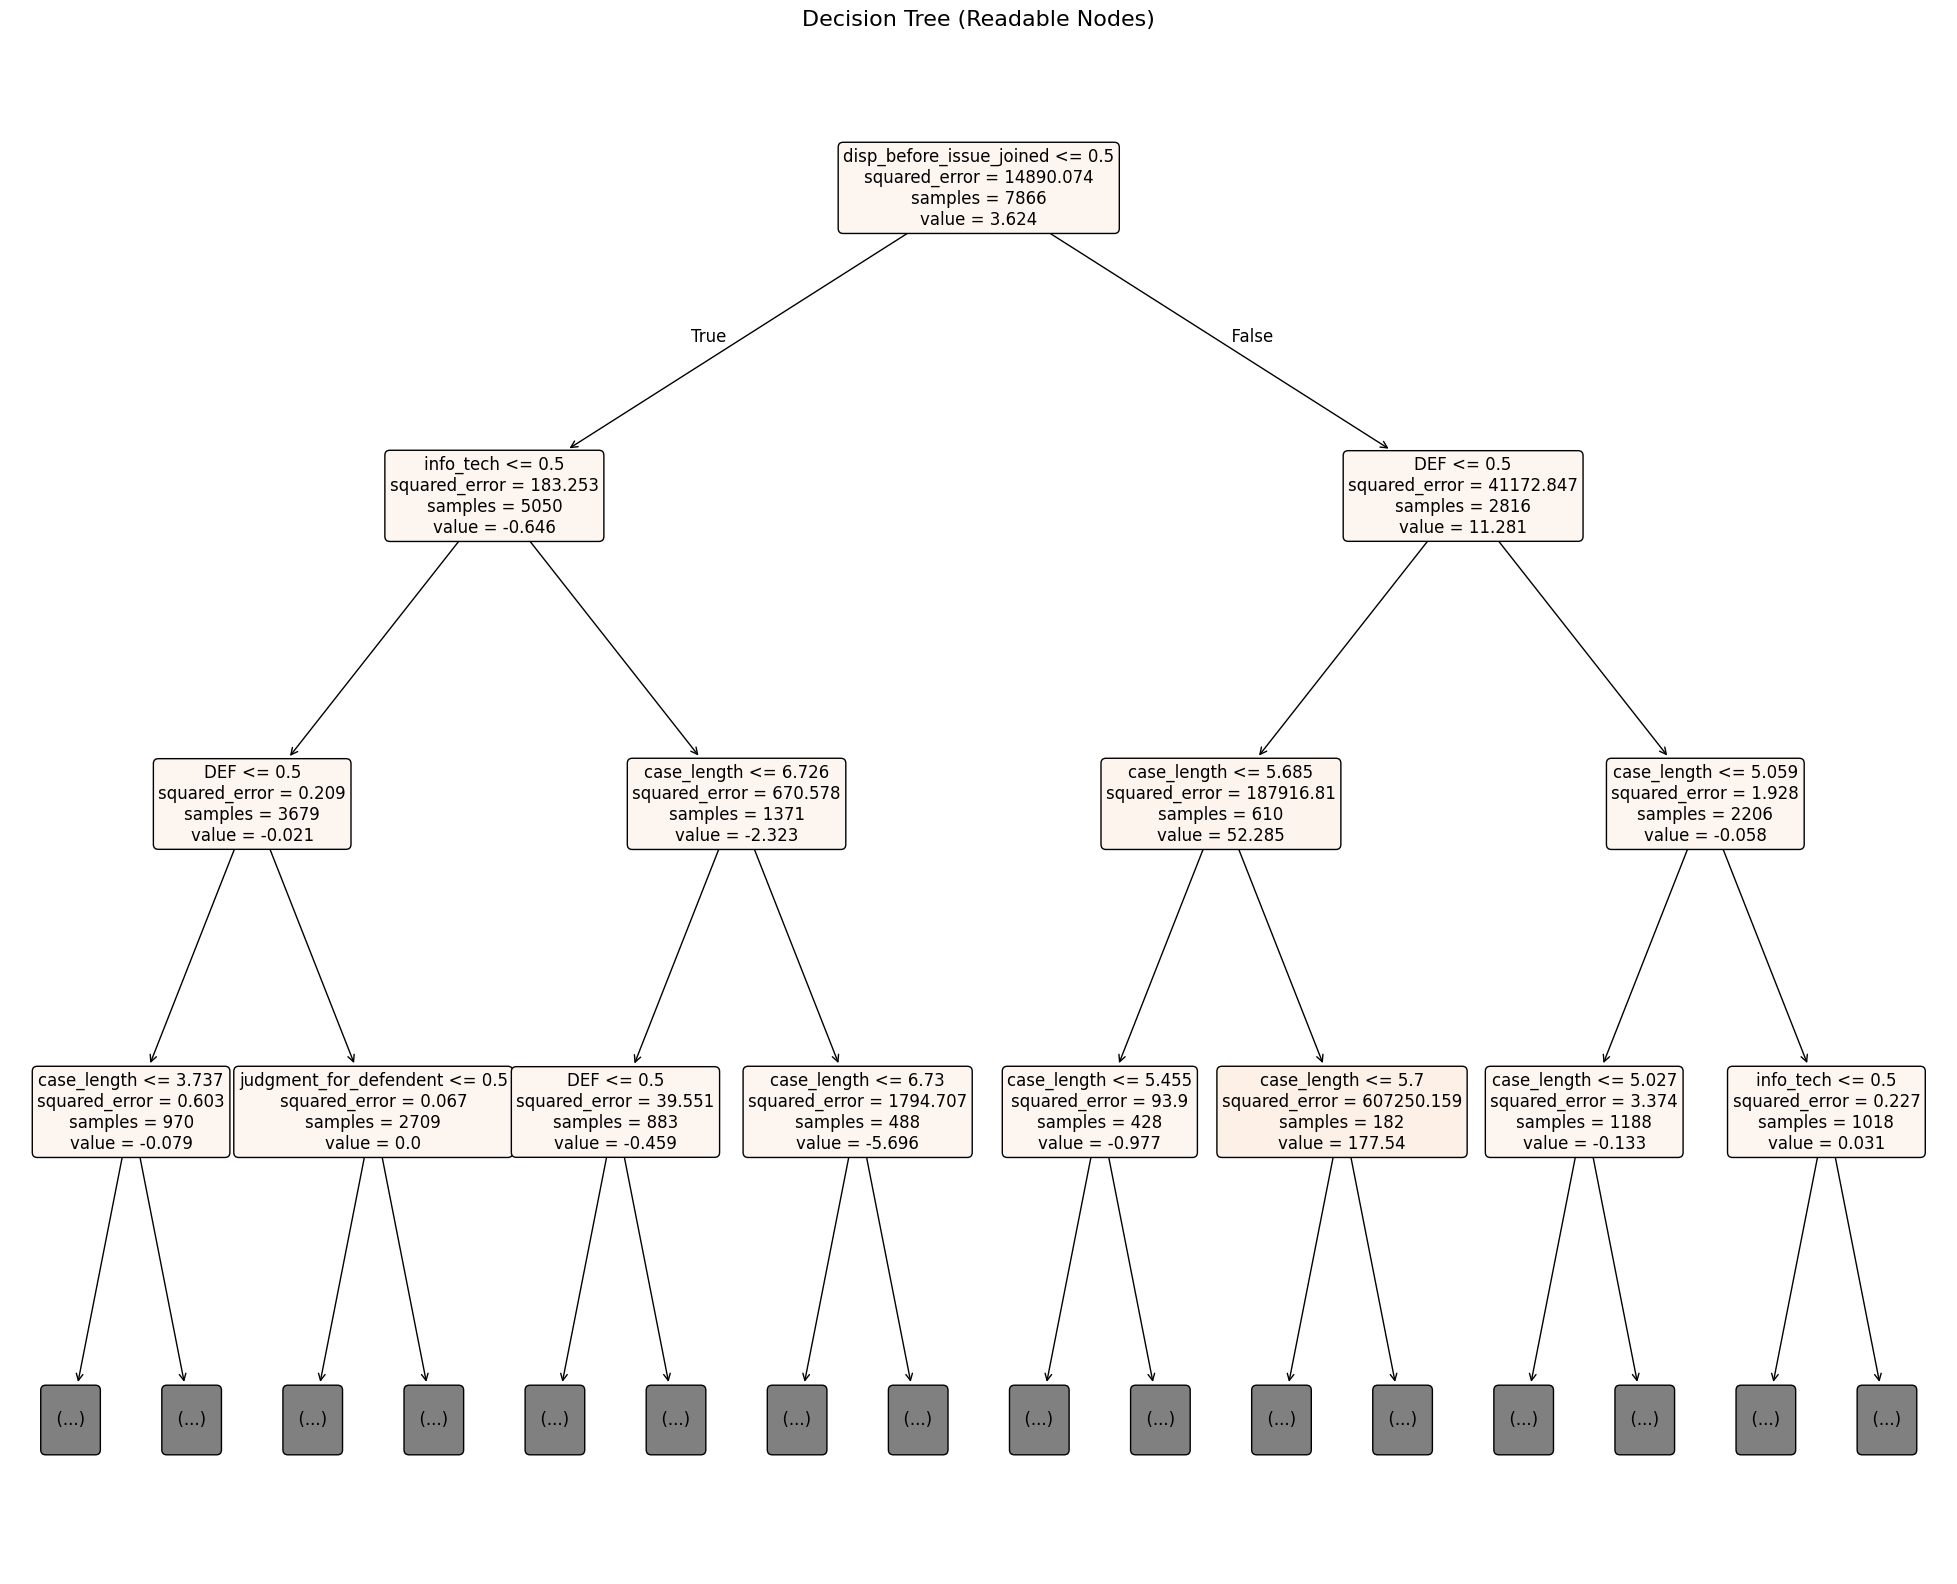

In [40]:
# Plot the decision tree with limited depth for visualization
plt.figure(figsize=(25, 20))  # You can adjust the figure size too
plot_tree(
    npm_regtree,
    feature_names=X_npm.columns,
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=12 )
plt.title("Decision Tree (Readable Nodes)", fontsize=16)
plt.show()

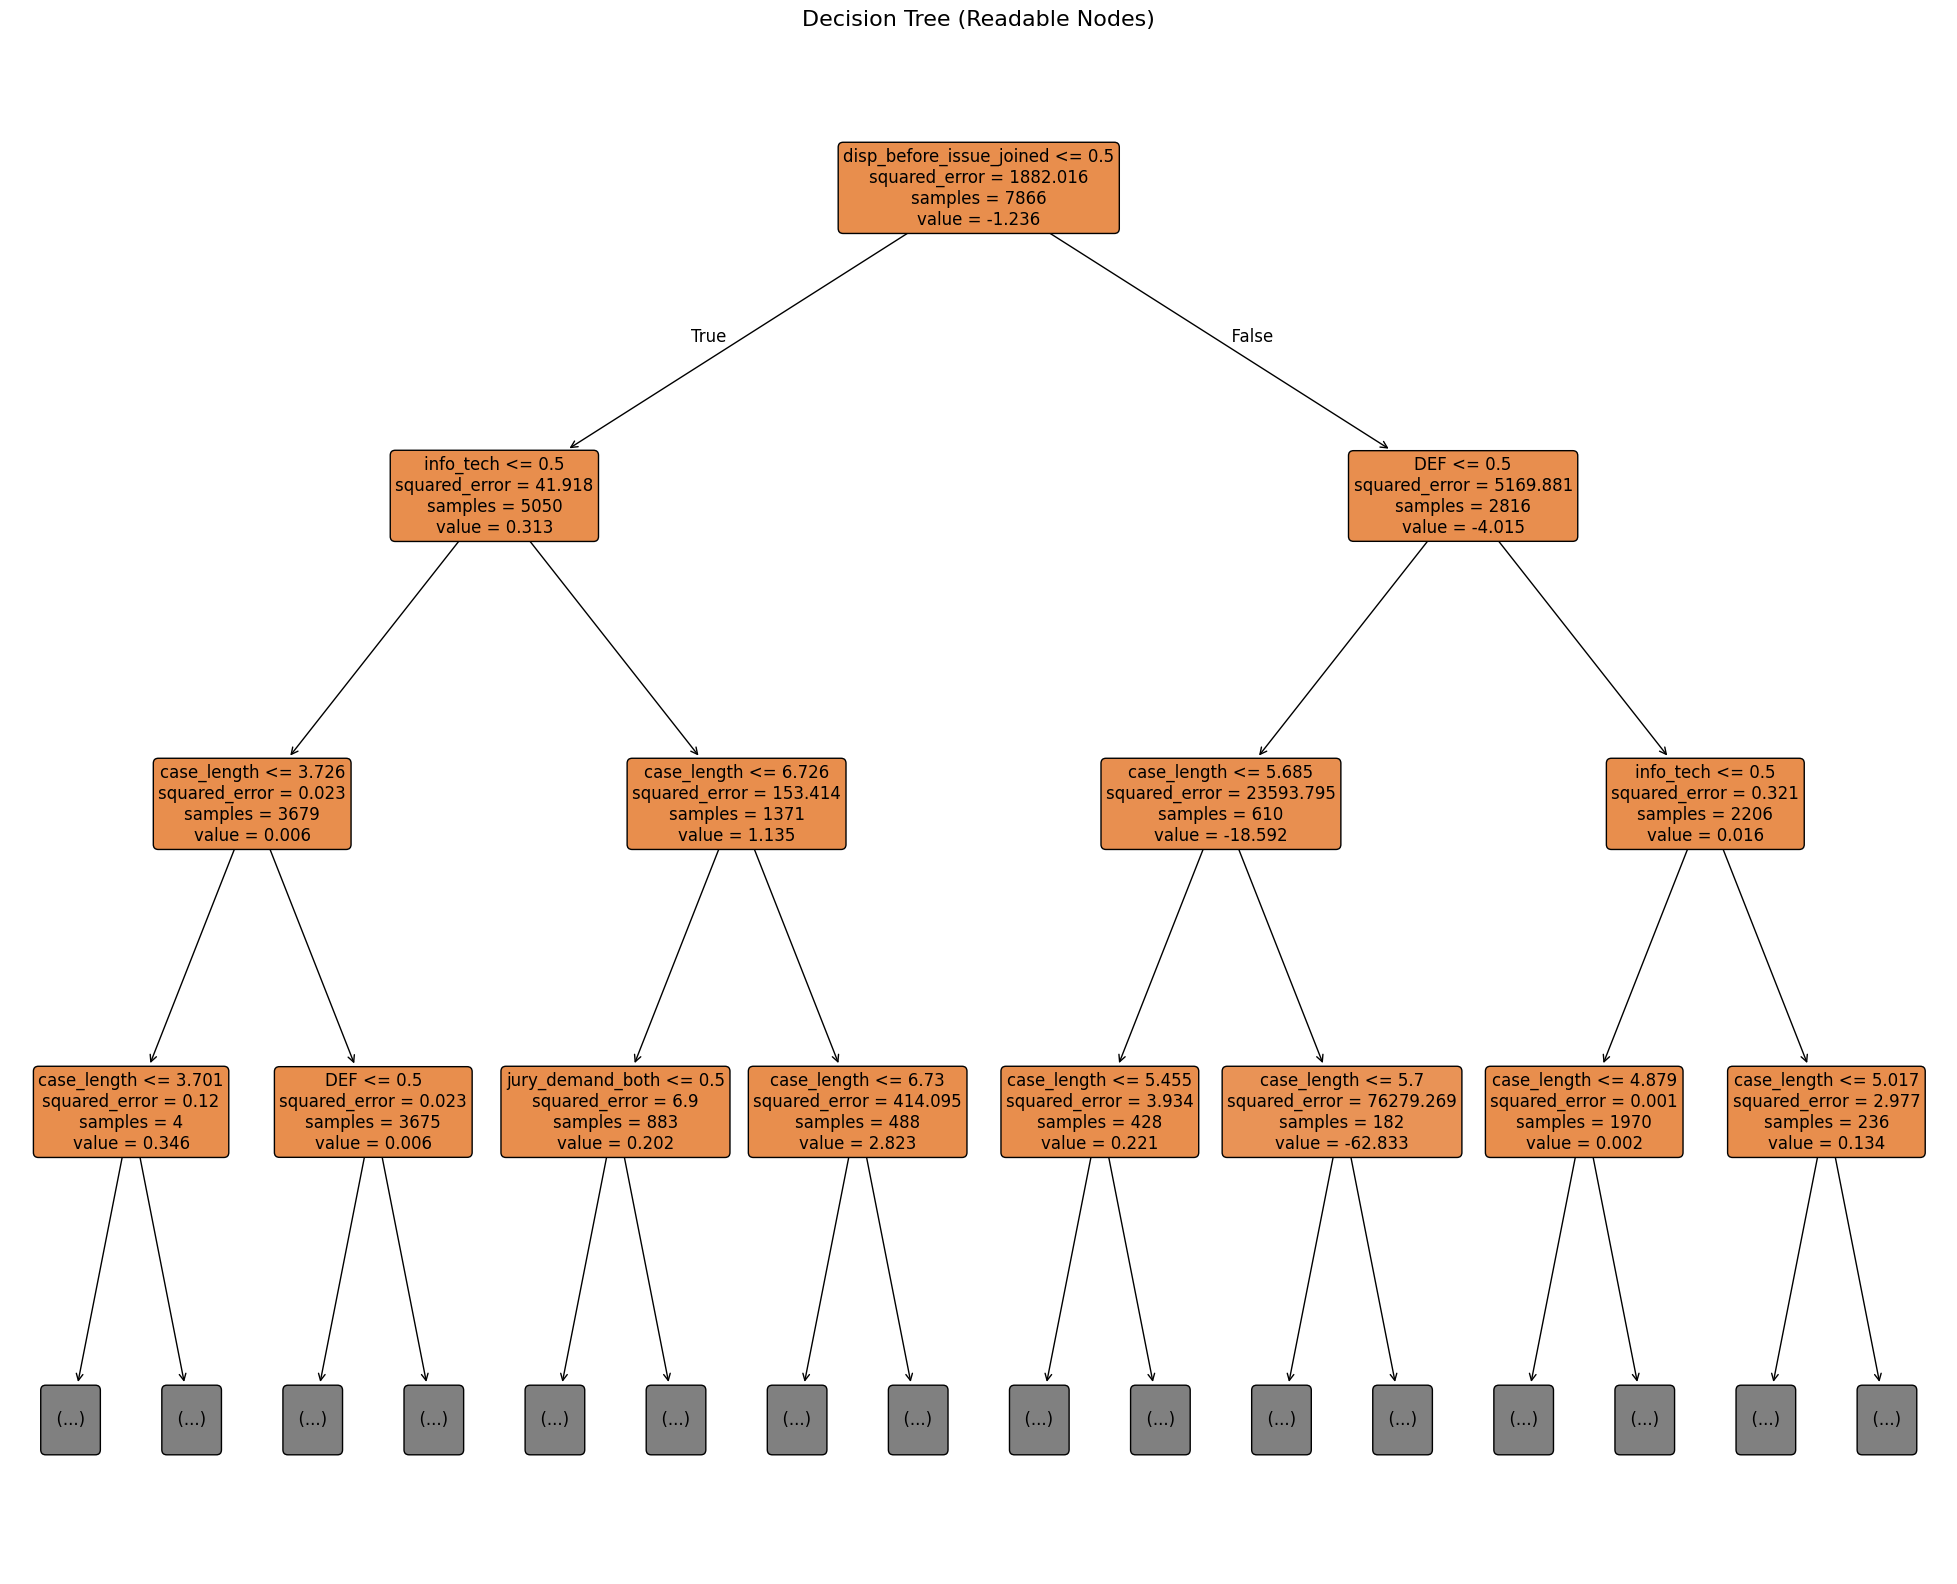

In [41]:
plt.figure(figsize=(25, 20))  # You can adjust the figure size too
plot_tree(
    rnd_regtree,
    feature_names=X_npm.columns,
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=12 )
plt.title("Decision Tree (Readable Nodes)", fontsize=16)
plt.show()

Performance Metrics for Regression Trees

preferred X:
1. Mean Squared Error (NPM): 50.326081040546306
2. R-Squarred (NPM): 0.9966201592173161
3. Mean Squared Error (R&D)): 27280.339229190573
4. R-Squarred (R&D): 0.9966201592173161

all X:
1. Mean Squared Error (NPM): 51.724922649918774
2. R-Squarred (NPM): 0.9965262146497654
3. Mean Squared Error (R&D)): 27277.979136528676
4. R-Squarred (R&D): 0.9965262146497654

Based on the four visualizations of the regression trees, we observe see that the nodes on the top do vary sometimes between the preferred specification and all X's. The preferred specification and has disp_before_issue_joined, info_tech sector and case length as the top nodes for the Net Profit Margin Tree, whereas the model with all X's has disp_before_issue_joined, info_tech and DEF (dummy = 1 if firm is defendent) as the top nodes. In addition, the preferred specification (for NPM) also outperforms the all predictor specification in terms of MSE, albeit marginally (50.32 for prefferred, 51.72 for all predictors).

For the Trees with the R&D to Sales Ratio models, we find that the top nodes in the prefferred specification are also disp_before_issue_joined, info_tech sector and case_length, and in the full model the topnodes are disp_before_issue_joined, info_tech and DEF- effectively mirroring the NPM model. We observe that the MSE is significantly higher compared to that of the NPM models- the prefferred specification with 27280.33 is outperformed by the full model which has an MSE of 27277.97, marginal difference again.

In terms of the error, looks like the R&D model is significantly worse, likely because it poorly predicts some extreme values which are disproportionately weighed by MSE(due to squarring effect). The R-squarred values are very close to 1 for all four of the models, but this is expected as the models are trained and evaluated on the same sample.

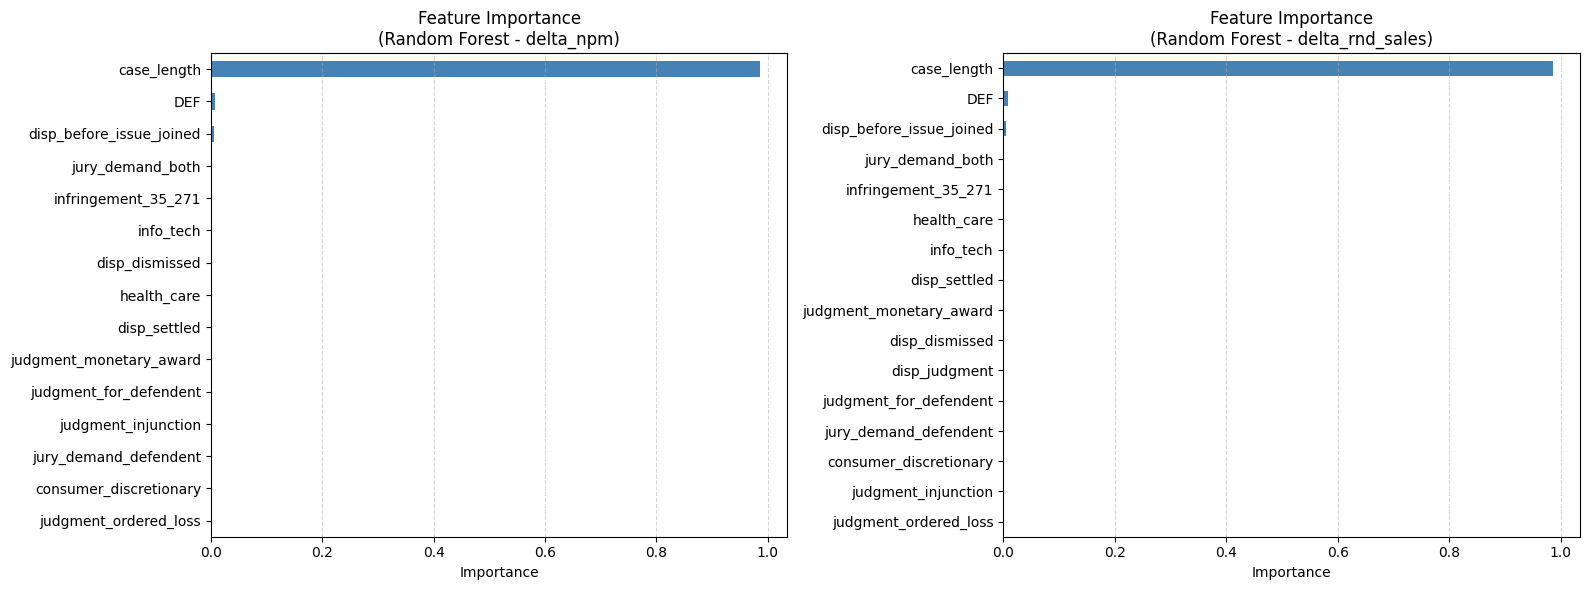

In [43]:
# Fitting Random Forrests Model
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Drop rows with NaNs in either target
complete_data = complete_data[
    complete_data['delta_npm'].notna() & complete_data['delta_rnd_sales'].notna()
]

# Shared feature set
features = [col for col in complete_data.columns if col not in ['delta_npm', 'delta_rnd_sales']]

# Model for delta_npm
X_npm = complete_data[features]
y_npm = complete_data['delta_npm']
rf_npm = RandomForestRegressor(random_state=42, max_depth=5)
rf_npm.fit(X_npm, y_npm)

# Model for delta_rnd_sales
X_rnd = complete_data[features]
y_rnd = complete_data['delta_rnd_sales']
rf_rnd = RandomForestRegressor(random_state=42, max_depth=5)
rf_rnd.fit(X_rnd, y_rnd)

# Extract and filter non-zero importances
importances_npm = pd.Series(rf_npm.feature_importances_, index=features)
importances_npm = importances_npm[importances_npm > 0].sort_values()

importances_rnd = pd.Series(rf_rnd.feature_importances_, index=features)
importances_rnd = importances_rnd[importances_rnd > 0].sort_values()

# Plot side-by-side axes
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Plot NPM
importances_npm.plot(kind='barh', color='steelblue', ax=axes[0])
axes[0].set_title('Feature Importance\n(Random Forest - delta_npm)')
axes[0].set_xlabel('Importance')
axes[0].grid(axis='x', linestyle='--', alpha=0.5)

# Plot RND
importances_rnd.plot(kind='barh', color='steelblue', ax=axes[1])
axes[1].set_title('Feature Importance\n(Random Forest - delta_rnd_sales)')
axes[1].set_xlabel('Importance')
axes[1].grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Looking at the feature importance matrices for the Random Forrests models, we see an interesting pitcure- the top predictors for both of the Y-variables is case length. This is particularly surprising at first glance as none of the coefficients for case length turned out to be statistically significant in our regressions. However, this results can be explained by the fact that case length is likely relavent, only through complex interactions with other featuers such the dummy DEF or disp_before_issue_joined. Since OLS models conditional distributions of the Y with respect to each of the predictors, it can only isolate the effect of a given predictor, holding all others constant. Therefore, OLS cannot model complex interactions, unless they are explicitly specified in the regression design.

This disparity yields a very important insight about the imapct of patent litigations on net profit margins and firm's research investment- while many firms are scared of lengthy litigation as a significant cause of financial strain, it would appear that the length of a case by itself doesn't impact a firm's finances and investment decision. The impact of length is likely most significant, in combination with other charecteristics of the case and firm in question.

# ***Section 10: Conclusion:***

So to conclude, at this stage of the procress, we have only obtained observational estimates of litigation impacts on firms' profitability and research investment. However, this has yielded some very unexpected and suprising findings. Our most significant and surprising results was the 4000 percentage point, average increase in profitability of plaintiff firms that sue and have their cases dismissed before issue joining. Additionally, we observed that defendants can also face significant losses in profit margins, up to 45 percentage points. We also noted that IT defendant firms tend to increase their investment in R&D to the order of roughly 8 percentage points while Healthcare Plaintiffs tend to reduce their R&D investments by a staggering 11000 percentage points on average.

While some of these estiamte effects are incredibly large and surprising, at this stage none of them represent causal impacts of litigation outcomes. The next step would be incorporate a valid causal inference appraoch and address endogeneity, in order to understand the true costs of patent litigations.  

These numbers may appear outrageous at first glance, factoring in the fact that these firms likely own mulitiple patents and enjoy a certain degree of Monopoly power, they become more beleivable. What is of interest is whether litigation outcomes are contributing to these massive profits and how much. This makes it even more

Our machine learning algorithms also suggest that the strongest predictor of both profit margins and research investment is the length of the case. But since we don't find a statistically significant effect of case length in our regressions, holding covariates constant, it is likely that case length is most significant, in complex interactions with other variables. This is a key insight into the factors affecting financial strain and researcge decision of firms involved in patent litiation.

# ***References:***

* Bessen, J. (2012). The market effects of patent litigation. Research Policy, 37(2), 374–387.

* Bessen, J., & Meurer, M. J. (2012). The private costs of patent litigation. Journal of Law, Economics & Policy, 9(1), 59–96.

* Cohen, L., Gurun, U. G., & Kominers, S. D. (2018). Patent trolls: Evidence from targeted firms. American Economic Review, 108(6), 2431–2469.

* Cremers, K., Gaessler, F., Harhoff, D., & Helmers, C. (2018). The effect of patent litigation on firm performance: Evidence from event studies. SciSpace Research.

* Hall, B. H. (2019). The impact of patent litigation on corporate strategy and performance. NBER Working Paper No. 13644.

* Kang, J., & Nam, K. M. (2016). Do firms profit from patent litigation? The contingent roles of innovation and internationalization. Journal of Business Research, 69(10), 4898–4905.

* Licht, G., & Cremers, K. (2013). The effect of patent litigation on firm performance. ZEW Discussion Paper No. 13-015.

* Lin, C.-H., & Lin, S.-C. (2021). Financial market reaction to patent lawsuits against integrated circuit firms. Journal of Risk and Financial Management, 14(9), Article 433
